In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
base_path = '../../'
sys.path.append(base_path)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import numpy as np
from tqdm import tqdm

# 3D U-Net with a small parameter count
class SmallUNet3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=5, base_filters=16):
        super(SmallUNet3D, self).__init__()
        self.enc1 = nn.Conv3d(in_channels, base_filters, kernel_size=3, padding=1)
        self.enc2 = nn.Conv3d(base_filters, base_filters * 2, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool3d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
        
        self.dec1 = nn.Conv3d(base_filters * 2, base_filters, kernel_size=3, padding=1)
        self.dec2 = nn.Conv3d(base_filters, out_channels, kernel_size=1)  # Final regression output

        self.act = nn.ReLU()
    
    def forward(self, x):
        e1 = self.act(self.enc1(x))
        e2 = self.act(self.enc2(self.pool(e1)))
        
        d1 = self.act(self.dec1(self.upsample(e2)))
        d2 = self.dec2(d1)  # No activation for regression
        
        return d2




# Initialize model and train
model = SmallUNet3D()


In [4]:
from src.pyvista_flow_field_dataset import PyvistaFlowFieldDataset
from src.voxel_flow_field_dataset import VoxelFlowFieldDataset, VoxelFlowFieldDatasetConfig
ds_pv = PyvistaFlowFieldDataset.load_from_huggingface(num_samples=200)
ds_voxel = VoxelFlowFieldDataset('datasets/voxels',VoxelFlowFieldDatasetConfig(ds_pv, resolution=(32,16,16)))
#ds_voxel = VoxelFlowFieldDataset('datasets/voxels')
ds_voxel.normalize()

Found 333 files in repository 'peteole/CoolMucSmall'.
File 1/400: volume_design_1.cgns already exists. Skipping download.
File 2/400: volume_design_10.cgns already exists. Skipping download.
File 3/400: volume_design_1001.cgns already exists. Skipping download.
File 4/400: volume_design_1002.cgns already exists. Skipping download.
File 5/400: volume_design_1003.cgns already exists. Skipping download.
File 6/400: volume_design_1004.cgns already exists. Skipping download.
File 7/400: volume_design_1005.cgns already exists. Skipping download.
File 8/400: volume_design_1006.cgns already exists. Skipping download.
File 9/400: volume_design_1007.cgns already exists. Skipping download.
File 10/400: volume_design_1008.cgns already exists. Skipping download.
File 11/400: volume_design_1009.cgns already exists. Skipping download.
File 12/400: volume_design_101.cgns already exists. Skipping download.
File 13/400: volume_design_1010.cgns already exists. Skipping download.
File 14/400: volume_desig

2025-03-27 06:49:18.579 (   4.590s) [    77115417B740]      vtkCGNSReader.cxx:4268  WARN| vtkCGNSReader (0x63d100365ed0): Skipping BC_t node: BC_t type 'BCInflow' not supported yet.
2025-03-27 06:49:18.579 (   4.590s) [    77115417B740]      vtkCGNSReader.cxx:4268  WARN| vtkCGNSReader (0x63d100365ed0): Skipping BC_t node: BC_t type 'BCSymmetryPlane' not supported yet.
2025-03-27 06:49:18.579 (   4.590s) [    77115417B740]      vtkCGNSReader.cxx:4268  WARN| vtkCGNSReader (0x63d100365ed0): Skipping BC_t node: BC_t type 'BCTunnelOutflow' not supported yet.
2025-03-27 06:49:18.700 (   4.710s) [    77115417B740]      vtkCGNSReader.cxx:4268  WARN| vtkCGNSReader (0x63d1018ba8b0): Skipping BC_t node: BC_t type 'BCInflow' not supported yet.
2025-03-27 06:49:18.700 (   4.710s) [    77115417B740]      vtkCGNSReader.cxx:4268  WARN| vtkCGNSReader (0x63d1018ba8b0): Skipping BC_t node: BC_t type 'BCSymmetryPlane' not supported yet.
2025-03-27 06:49:18.700 (   4.710s) [    77115417B740]      vtkCGNSRe

In [5]:

import torch.utils.data as data
dataloader = data.DataLoader(ds_voxel.get_default_loadable_dataset(), batch_size=3, shuffle=True)

In [6]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)
criterion = nn.MSELoss()
lr=1e-3
epochs=1000
optimizer = optim.Adam(model.parameters(), lr=lr)
losses = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for x,y in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
        x, y = x.to(device), y.to(device)
        x=x.float().unsqueeze(-1)
        x = x.permute(0, 4, 1, 2, 3)  # (N, D, H, W, C) → (N, C, D, H, W)
        y = y.permute(0, 4, 1, 2, 3)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    losses.append(epoch_loss / len(dataloader))
    print(f"Epoch {epoch+1}, Loss: {epoch_loss / len(dataloader)}")

Using device: cuda


Epoch 1/1000: 100%|██████████| 66/66 [00:00<00:00, 136.00it/s]


Epoch 1, Loss: 5.771272043387095


Epoch 2/1000: 100%|██████████| 66/66 [00:00<00:00, 321.38it/s]


Epoch 2, Loss: 5.575748031789606


Epoch 3/1000: 100%|██████████| 66/66 [00:00<00:00, 320.91it/s]


Epoch 3, Loss: 5.439755498008295


Epoch 4/1000: 100%|██████████| 66/66 [00:00<00:00, 325.76it/s]


Epoch 4, Loss: 5.3762311005231105


Epoch 5/1000: 100%|██████████| 66/66 [00:00<00:00, 347.81it/s]


Epoch 5, Loss: 5.360420993783257


Epoch 6/1000: 100%|██████████| 66/66 [00:00<00:00, 324.89it/s]


Epoch 6, Loss: 5.318877099589868


Epoch 7/1000: 100%|██████████| 66/66 [00:00<00:00, 326.22it/s]


Epoch 7, Loss: 5.291314756779959


Epoch 8/1000: 100%|██████████| 66/66 [00:00<00:00, 324.58it/s]


Epoch 8, Loss: 5.251236762964364


Epoch 9/1000: 100%|██████████| 66/66 [00:00<00:00, 334.15it/s]


Epoch 9, Loss: 5.2228072118578535


Epoch 10/1000: 100%|██████████| 66/66 [00:00<00:00, 386.82it/s]


Epoch 10, Loss: 5.222084318598111


Epoch 11/1000: 100%|██████████| 66/66 [00:00<00:00, 362.33it/s]


Epoch 11, Loss: 5.1046431990283905


Epoch 12/1000: 100%|██████████| 66/66 [00:00<00:00, 350.07it/s]


Epoch 12, Loss: 5.139319478788159


Epoch 13/1000: 100%|██████████| 66/66 [00:00<00:00, 327.93it/s]


Epoch 13, Loss: 5.136780559113531


Epoch 14/1000: 100%|██████████| 66/66 [00:00<00:00, 385.40it/s]


Epoch 14, Loss: 4.975650683045387


Epoch 15/1000: 100%|██████████| 66/66 [00:00<00:00, 392.18it/s]


Epoch 15, Loss: 5.025079769167033


Epoch 16/1000: 100%|██████████| 66/66 [00:00<00:00, 327.55it/s]


Epoch 16, Loss: 4.975894645759554


Epoch 17/1000: 100%|██████████| 66/66 [00:00<00:00, 326.06it/s]


Epoch 17, Loss: 4.996104573661631


Epoch 18/1000: 100%|██████████| 66/66 [00:00<00:00, 325.36it/s]


Epoch 18, Loss: 4.9569226124069905


Epoch 19/1000: 100%|██████████| 66/66 [00:00<00:00, 360.44it/s]


Epoch 19, Loss: 4.981422654155529


Epoch 20/1000: 100%|██████████| 66/66 [00:00<00:00, 335.60it/s]


Epoch 20, Loss: 4.8844867113864785


Epoch 21/1000: 100%|██████████| 66/66 [00:00<00:00, 342.18it/s]


Epoch 21, Loss: 5.007613049086296


Epoch 22/1000: 100%|██████████| 66/66 [00:00<00:00, 322.18it/s]


Epoch 22, Loss: 4.882974327513666


Epoch 23/1000: 100%|██████████| 66/66 [00:00<00:00, 316.79it/s]


Epoch 23, Loss: 4.84028218528538


Epoch 24/1000: 100%|██████████| 66/66 [00:00<00:00, 325.83it/s]


Epoch 24, Loss: 4.781191673468459


Epoch 25/1000: 100%|██████████| 66/66 [00:00<00:00, 325.88it/s]


Epoch 25, Loss: 4.924444296143272


Epoch 26/1000: 100%|██████████| 66/66 [00:00<00:00, 326.01it/s]


Epoch 26, Loss: 4.8683316953706015


Epoch 27/1000: 100%|██████████| 66/66 [00:00<00:00, 325.90it/s]


Epoch 27, Loss: 4.822700564156879


Epoch 28/1000: 100%|██████████| 66/66 [00:00<00:00, 326.97it/s]


Epoch 28, Loss: 4.776318285501365


Epoch 29/1000: 100%|██████████| 66/66 [00:00<00:00, 493.58it/s]


Epoch 29, Loss: 4.781418098870552


Epoch 30/1000: 100%|██████████| 66/66 [00:00<00:00, 322.23it/s]


Epoch 30, Loss: 4.860018408659733


Epoch 31/1000: 100%|██████████| 66/66 [00:00<00:00, 333.45it/s]


Epoch 31, Loss: 4.738144157510815


Epoch 32/1000: 100%|██████████| 66/66 [00:00<00:00, 390.78it/s]


Epoch 32, Loss: 4.7336643480441785


Epoch 33/1000: 100%|██████████| 66/66 [00:00<00:00, 336.73it/s]


Epoch 33, Loss: 4.667886409569871


Epoch 34/1000: 100%|██████████| 66/66 [00:00<00:00, 325.22it/s]


Epoch 34, Loss: 4.689781584974491


Epoch 35/1000: 100%|██████████| 66/66 [00:00<00:00, 326.00it/s]


Epoch 35, Loss: 4.905823262126157


Epoch 36/1000: 100%|██████████| 66/66 [00:00<00:00, 326.10it/s]


Epoch 36, Loss: 4.672430671977274


Epoch 37/1000: 100%|██████████| 66/66 [00:00<00:00, 324.59it/s]


Epoch 37, Loss: 4.661424080756578


Epoch 38/1000: 100%|██████████| 66/66 [00:00<00:00, 323.19it/s]


Epoch 38, Loss: 4.69953283735297


Epoch 39/1000: 100%|██████████| 66/66 [00:00<00:00, 325.33it/s]


Epoch 39, Loss: 4.686126248854579


Epoch 40/1000: 100%|██████████| 66/66 [00:00<00:00, 325.86it/s]


Epoch 40, Loss: 4.6277590908787465


Epoch 41/1000: 100%|██████████| 66/66 [00:00<00:00, 326.38it/s]


Epoch 41, Loss: 4.662855284909408


Epoch 42/1000: 100%|██████████| 66/66 [00:00<00:00, 326.84it/s]


Epoch 42, Loss: 4.784439885706613


Epoch 43/1000: 100%|██████████| 66/66 [00:00<00:00, 326.94it/s]


Epoch 43, Loss: 4.671251817860386


Epoch 44/1000: 100%|██████████| 66/66 [00:00<00:00, 324.14it/s]


Epoch 44, Loss: 4.648758228078033


Epoch 45/1000: 100%|██████████| 66/66 [00:00<00:00, 325.97it/s]


Epoch 45, Loss: 4.60922365658211


Epoch 46/1000: 100%|██████████| 66/66 [00:00<00:00, 325.94it/s]


Epoch 46, Loss: 4.5820807746865535


Epoch 47/1000: 100%|██████████| 66/66 [00:00<00:00, 326.25it/s]


Epoch 47, Loss: 4.553240789834297


Epoch 48/1000: 100%|██████████| 66/66 [00:00<00:00, 326.86it/s]


Epoch 48, Loss: 4.562226535695972


Epoch 49/1000: 100%|██████████| 66/66 [00:00<00:00, 326.27it/s]


Epoch 49, Loss: 4.507261805010565


Epoch 50/1000: 100%|██████████| 66/66 [00:00<00:00, 416.50it/s]


Epoch 50, Loss: 4.56833203881979


Epoch 51/1000: 100%|██████████| 66/66 [00:00<00:00, 315.78it/s]


Epoch 51, Loss: 4.477154857281483


Epoch 52/1000: 100%|██████████| 66/66 [00:00<00:00, 326.62it/s]


Epoch 52, Loss: 4.473265407663403


Epoch 53/1000: 100%|██████████| 66/66 [00:00<00:00, 383.96it/s]


Epoch 53, Loss: 4.581549123606899


Epoch 54/1000: 100%|██████████| 66/66 [00:00<00:00, 339.67it/s]


Epoch 54, Loss: 4.529252854260531


Epoch 55/1000: 100%|██████████| 66/66 [00:00<00:00, 322.18it/s]


Epoch 55, Loss: 4.462068359734434


Epoch 56/1000: 100%|██████████| 66/66 [00:00<00:00, 324.96it/s]


Epoch 56, Loss: 4.481025357589577


Epoch 57/1000: 100%|██████████| 66/66 [00:00<00:00, 326.16it/s]


Epoch 57, Loss: 4.413418197947921


Epoch 58/1000: 100%|██████████| 66/66 [00:00<00:00, 301.39it/s]


Epoch 58, Loss: 4.562794394565351


Epoch 59/1000: 100%|██████████| 66/66 [00:00<00:00, 348.72it/s]


Epoch 59, Loss: 4.4045968466635905


Epoch 60/1000: 100%|██████████| 66/66 [00:00<00:00, 349.08it/s]


Epoch 60, Loss: 4.459138628659827


Epoch 61/1000: 100%|██████████| 66/66 [00:00<00:00, 344.70it/s]


Epoch 61, Loss: 4.60388474414746


Epoch 62/1000: 100%|██████████| 66/66 [00:00<00:00, 325.82it/s]


Epoch 62, Loss: 4.4106474130442646


Epoch 63/1000: 100%|██████████| 66/66 [00:00<00:00, 326.38it/s]


Epoch 63, Loss: 4.427186161957004


Epoch 64/1000: 100%|██████████| 66/66 [00:00<00:00, 325.91it/s]


Epoch 64, Loss: 4.342731441512252


Epoch 65/1000: 100%|██████████| 66/66 [00:00<00:00, 326.00it/s]


Epoch 65, Loss: 4.3330748641129695


Epoch 66/1000: 100%|██████████| 66/66 [00:00<00:00, 321.55it/s]


Epoch 66, Loss: 4.330951244993643


Epoch 67/1000: 100%|██████████| 66/66 [00:00<00:00, 337.19it/s]


Epoch 67, Loss: 4.318391766286258


Epoch 68/1000: 100%|██████████| 66/66 [00:00<00:00, 323.02it/s]


Epoch 68, Loss: 4.418384333000039


Epoch 69/1000: 100%|██████████| 66/66 [00:00<00:00, 321.14it/s]


Epoch 69, Loss: 4.305674856133534


Epoch 70/1000: 100%|██████████| 66/66 [00:00<00:00, 370.32it/s]


Epoch 70, Loss: 4.312666183394013


Epoch 71/1000: 100%|██████████| 66/66 [00:00<00:00, 348.14it/s]


Epoch 71, Loss: 4.421592038689238


Epoch 72/1000: 100%|██████████| 66/66 [00:00<00:00, 354.25it/s]


Epoch 72, Loss: 4.459779203163855


Epoch 73/1000: 100%|██████████| 66/66 [00:00<00:00, 322.99it/s]


Epoch 73, Loss: 4.350458253513683


Epoch 74/1000: 100%|██████████| 66/66 [00:00<00:00, 318.78it/s]


Epoch 74, Loss: 4.2938778021118855


Epoch 75/1000: 100%|██████████| 66/66 [00:00<00:00, 326.14it/s]


Epoch 75, Loss: 4.333932576080163


Epoch 76/1000: 100%|██████████| 66/66 [00:00<00:00, 326.10it/s]


Epoch 76, Loss: 4.203197328881784


Epoch 77/1000: 100%|██████████| 66/66 [00:00<00:00, 403.31it/s]


Epoch 77, Loss: 4.1899106172901215


Epoch 78/1000: 100%|██████████| 66/66 [00:00<00:00, 406.61it/s]


Epoch 78, Loss: 4.280557551167228


Epoch 79/1000: 100%|██████████| 66/66 [00:00<00:00, 447.39it/s]


Epoch 79, Loss: 4.4203359238577615


Epoch 80/1000: 100%|██████████| 66/66 [00:00<00:00, 330.26it/s]


Epoch 80, Loss: 4.242464389313351


Epoch 81/1000: 100%|██████████| 66/66 [00:00<00:00, 333.55it/s]


Epoch 81, Loss: 4.2844746460517245


Epoch 82/1000: 100%|██████████| 66/66 [00:00<00:00, 326.56it/s]


Epoch 82, Loss: 4.192201373929327


Epoch 83/1000: 100%|██████████| 66/66 [00:00<00:00, 326.27it/s]


Epoch 83, Loss: 4.233681004155766


Epoch 84/1000: 100%|██████████| 66/66 [00:00<00:00, 326.21it/s]


Epoch 84, Loss: 4.1788577344833


Epoch 85/1000: 100%|██████████| 66/66 [00:00<00:00, 325.96it/s]


Epoch 85, Loss: 4.128461735266628


Epoch 86/1000: 100%|██████████| 66/66 [00:00<00:00, 325.90it/s]


Epoch 86, Loss: 4.103903691199693


Epoch 87/1000: 100%|██████████| 66/66 [00:00<00:00, 324.85it/s]


Epoch 87, Loss: 4.081766259489638


Epoch 88/1000: 100%|██████████| 66/66 [00:00<00:00, 326.27it/s]


Epoch 88, Loss: 4.134150082189025


Epoch 89/1000: 100%|██████████| 66/66 [00:00<00:00, 326.38it/s]


Epoch 89, Loss: 4.057162366581686


Epoch 90/1000: 100%|██████████| 66/66 [00:00<00:00, 326.22it/s]


Epoch 90, Loss: 4.032863070115899


Epoch 91/1000: 100%|██████████| 66/66 [00:00<00:00, 326.16it/s]


Epoch 91, Loss: 4.161368146538734


Epoch 92/1000: 100%|██████████| 66/66 [00:00<00:00, 325.92it/s]


Epoch 92, Loss: 4.245616307538567


Epoch 93/1000: 100%|██████████| 66/66 [00:00<00:00, 326.04it/s]


Epoch 93, Loss: 4.039894380804264


Epoch 94/1000: 100%|██████████| 66/66 [00:00<00:00, 324.95it/s]


Epoch 94, Loss: 4.082303479539625


Epoch 95/1000: 100%|██████████| 66/66 [00:00<00:00, 325.95it/s]


Epoch 95, Loss: 4.1603078225796875


Epoch 96/1000: 100%|██████████| 66/66 [00:00<00:00, 326.32it/s]


Epoch 96, Loss: 4.075367295606569


Epoch 97/1000: 100%|██████████| 66/66 [00:00<00:00, 327.24it/s]


Epoch 97, Loss: 4.029821742664684


Epoch 98/1000: 100%|██████████| 66/66 [00:00<00:00, 326.20it/s]


Epoch 98, Loss: 4.045326793735677


Epoch 99/1000: 100%|██████████| 66/66 [00:00<00:00, 326.20it/s]


Epoch 99, Loss: 4.018722522665154


Epoch 100/1000: 100%|██████████| 66/66 [00:00<00:00, 326.51it/s]


Epoch 100, Loss: 3.919281130938819


Epoch 101/1000: 100%|██████████| 66/66 [00:00<00:00, 323.57it/s]


Epoch 101, Loss: 4.032615621207339


Epoch 102/1000: 100%|██████████| 66/66 [00:00<00:00, 326.09it/s]


Epoch 102, Loss: 3.936112719503316


Epoch 103/1000: 100%|██████████| 66/66 [00:00<00:00, 326.08it/s]


Epoch 103, Loss: 3.9658140632690806


Epoch 104/1000: 100%|██████████| 66/66 [00:00<00:00, 325.95it/s]


Epoch 104, Loss: 3.9760998257181863


Epoch 105/1000: 100%|██████████| 66/66 [00:00<00:00, 325.89it/s]


Epoch 105, Loss: 3.9594710850805948


Epoch 106/1000: 100%|██████████| 66/66 [00:00<00:00, 325.73it/s]


Epoch 106, Loss: 4.0717443970568254


Epoch 107/1000: 100%|██████████| 66/66 [00:00<00:00, 327.48it/s]


Epoch 107, Loss: 4.00085730782964


Epoch 108/1000: 100%|██████████| 66/66 [00:00<00:00, 324.74it/s]


Epoch 108, Loss: 3.968364378719619


Epoch 109/1000: 100%|██████████| 66/66 [00:00<00:00, 326.33it/s]


Epoch 109, Loss: 3.8669299363638414


Epoch 110/1000: 100%|██████████| 66/66 [00:00<00:00, 325.99it/s]


Epoch 110, Loss: 3.9459932132652313


Epoch 111/1000: 100%|██████████| 66/66 [00:00<00:00, 326.18it/s]


Epoch 111, Loss: 3.9777327584046307


Epoch 112/1000: 100%|██████████| 66/66 [00:00<00:00, 325.98it/s]


Epoch 112, Loss: 3.9089401682669465


Epoch 113/1000: 100%|██████████| 66/66 [00:00<00:00, 325.87it/s]


Epoch 113, Loss: 4.020704878776362


Epoch 114/1000: 100%|██████████| 66/66 [00:00<00:00, 325.86it/s]


Epoch 114, Loss: 3.922761805807099


Epoch 115/1000: 100%|██████████| 66/66 [00:00<00:00, 324.53it/s]


Epoch 115, Loss: 3.906776568880587


Epoch 116/1000: 100%|██████████| 66/66 [00:00<00:00, 326.06it/s]


Epoch 116, Loss: 3.884269790667476


Epoch 117/1000: 100%|██████████| 66/66 [00:00<00:00, 328.49it/s]


Epoch 117, Loss: 3.909421543957609


Epoch 118/1000: 100%|██████████| 66/66 [00:00<00:00, 326.05it/s]


Epoch 118, Loss: 3.7733477959127137


Epoch 119/1000: 100%|██████████| 66/66 [00:00<00:00, 326.31it/s]


Epoch 119, Loss: 3.8583726063370705


Epoch 120/1000: 100%|██████████| 66/66 [00:00<00:00, 326.20it/s]


Epoch 120, Loss: 3.8509760768801877


Epoch 121/1000: 100%|██████████| 66/66 [00:00<00:00, 325.71it/s]


Epoch 121, Loss: 3.9417893261168944


Epoch 122/1000: 100%|██████████| 66/66 [00:00<00:00, 324.31it/s]


Epoch 122, Loss: 3.834356929993991


Epoch 123/1000: 100%|██████████| 66/66 [00:00<00:00, 326.64it/s]


Epoch 123, Loss: 3.793848010400931


Epoch 124/1000: 100%|██████████| 66/66 [00:00<00:00, 326.09it/s]


Epoch 124, Loss: 3.780691153172291


Epoch 125/1000: 100%|██████████| 66/66 [00:00<00:00, 326.16it/s]


Epoch 125, Loss: 4.065198450151718


Epoch 126/1000: 100%|██████████| 66/66 [00:00<00:00, 312.47it/s]


Epoch 126, Loss: 3.784589259461923


Epoch 127/1000: 100%|██████████| 66/66 [00:00<00:00, 328.57it/s]


Epoch 127, Loss: 3.805151663494833


Epoch 128/1000: 100%|██████████| 66/66 [00:00<00:00, 324.08it/s]


Epoch 128, Loss: 3.7662068463184615


Epoch 129/1000: 100%|██████████| 66/66 [00:00<00:00, 322.98it/s]


Epoch 129, Loss: 3.799276332060496


Epoch 130/1000: 100%|██████████| 66/66 [00:00<00:00, 340.12it/s]


Epoch 130, Loss: 4.161659746684811


Epoch 131/1000: 100%|██████████| 66/66 [00:00<00:00, 325.42it/s]


Epoch 131, Loss: 3.7367946607145397


Epoch 132/1000: 100%|██████████| 66/66 [00:00<00:00, 325.84it/s]


Epoch 132, Loss: 3.796876369777954


Epoch 133/1000: 100%|██████████| 66/66 [00:00<00:00, 326.19it/s]


Epoch 133, Loss: 3.7030691010030834


Epoch 134/1000: 100%|██████████| 66/66 [00:00<00:00, 326.27it/s]


Epoch 134, Loss: 3.735091247567625


Epoch 135/1000: 100%|██████████| 66/66 [00:00<00:00, 325.84it/s]


Epoch 135, Loss: 3.824624566417752


Epoch 136/1000: 100%|██████████| 66/66 [00:00<00:00, 332.22it/s]


Epoch 136, Loss: 3.8616683675032673


Epoch 137/1000: 100%|██████████| 66/66 [00:00<00:00, 530.43it/s]


Epoch 137, Loss: 3.8866076799053135


Epoch 138/1000: 100%|██████████| 66/66 [00:00<00:00, 368.41it/s]


Epoch 138, Loss: 3.6796222297531185


Epoch 139/1000: 100%|██████████| 66/66 [00:00<00:00, 323.75it/s]


Epoch 139, Loss: 3.823308366266164


Epoch 140/1000: 100%|██████████| 66/66 [00:00<00:00, 326.28it/s]


Epoch 140, Loss: 3.6826863638830907


Epoch 141/1000: 100%|██████████| 66/66 [00:00<00:00, 326.40it/s]


Epoch 141, Loss: 3.847123405698574


Epoch 142/1000: 100%|██████████| 66/66 [00:00<00:00, 326.56it/s]


Epoch 142, Loss: 3.6279127846161523


Epoch 143/1000: 100%|██████████| 66/66 [00:00<00:00, 323.60it/s]


Epoch 143, Loss: 3.982067549093203


Epoch 144/1000: 100%|██████████| 66/66 [00:00<00:00, 326.66it/s]


Epoch 144, Loss: 3.793070974675092


Epoch 145/1000: 100%|██████████| 66/66 [00:00<00:00, 362.45it/s]


Epoch 145, Loss: 3.630251487096151


Epoch 146/1000: 100%|██████████| 66/66 [00:00<00:00, 325.23it/s]


Epoch 146, Loss: 3.6107549626718867


Epoch 147/1000: 100%|██████████| 66/66 [00:00<00:00, 471.08it/s]


Epoch 147, Loss: 3.7326287349516694


Epoch 148/1000: 100%|██████████| 66/66 [00:00<00:00, 410.87it/s]


Epoch 148, Loss: 3.8030404615582842


Epoch 149/1000: 100%|██████████| 66/66 [00:00<00:00, 464.76it/s]


Epoch 149, Loss: 3.823923872501561


Epoch 150/1000: 100%|██████████| 66/66 [00:00<00:00, 321.99it/s]


Epoch 150, Loss: 3.610018006779931


Epoch 151/1000: 100%|██████████| 66/66 [00:00<00:00, 355.57it/s]


Epoch 151, Loss: 3.6305877923062355


Epoch 152/1000: 100%|██████████| 66/66 [00:00<00:00, 370.62it/s]


Epoch 152, Loss: 3.6366201691103703


Epoch 153/1000: 100%|██████████| 66/66 [00:00<00:00, 323.10it/s]


Epoch 153, Loss: 3.6491595673741717


Epoch 154/1000: 100%|██████████| 66/66 [00:00<00:00, 347.51it/s]


Epoch 154, Loss: 3.6754608842911143


Epoch 155/1000: 100%|██████████| 66/66 [00:00<00:00, 355.37it/s]


Epoch 155, Loss: 3.7562389409903325


Epoch 156/1000: 100%|██████████| 66/66 [00:00<00:00, 584.80it/s]


Epoch 156, Loss: 3.6204630001024767


Epoch 157/1000: 100%|██████████| 66/66 [00:00<00:00, 338.30it/s]


Epoch 157, Loss: 3.5981673593773986


Epoch 158/1000: 100%|██████████| 66/66 [00:00<00:00, 380.26it/s]


Epoch 158, Loss: 3.5617779080163348


Epoch 159/1000: 100%|██████████| 66/66 [00:00<00:00, 338.64it/s]


Epoch 159, Loss: 3.5592005546345855


Epoch 160/1000: 100%|██████████| 66/66 [00:00<00:00, 327.26it/s]


Epoch 160, Loss: 3.6893190143234804


Epoch 161/1000: 100%|██████████| 66/66 [00:00<00:00, 361.35it/s]


Epoch 161, Loss: 3.6574336513876915


Epoch 162/1000: 100%|██████████| 66/66 [00:00<00:00, 365.63it/s]


Epoch 162, Loss: 3.7429962381720543


Epoch 163/1000: 100%|██████████| 66/66 [00:00<00:00, 365.99it/s]


Epoch 163, Loss: 3.629540132979552


Epoch 164/1000: 100%|██████████| 66/66 [00:00<00:00, 289.28it/s]


Epoch 164, Loss: 3.762559037091154


Epoch 165/1000: 100%|██████████| 66/66 [00:00<00:00, 325.07it/s]


Epoch 165, Loss: 3.670740009708838


Epoch 166/1000: 100%|██████████| 66/66 [00:00<00:00, 321.89it/s]


Epoch 166, Loss: 3.626178940814553


Epoch 167/1000: 100%|██████████| 66/66 [00:00<00:00, 323.55it/s]


Epoch 167, Loss: 3.583199082224658


Epoch 168/1000: 100%|██████████| 66/66 [00:00<00:00, 323.16it/s]


Epoch 168, Loss: 3.5370988421367877


Epoch 169/1000: 100%|██████████| 66/66 [00:00<00:00, 377.36it/s]


Epoch 169, Loss: 3.6847939789295197


Epoch 170/1000: 100%|██████████| 66/66 [00:00<00:00, 315.91it/s]


Epoch 170, Loss: 3.6112550738634486


Epoch 171/1000: 100%|██████████| 66/66 [00:00<00:00, 490.54it/s]


Epoch 171, Loss: 3.5934979741772017


Epoch 172/1000: 100%|██████████| 66/66 [00:00<00:00, 409.84it/s]


Epoch 172, Loss: 3.5319064352096934


Epoch 173/1000: 100%|██████████| 66/66 [00:00<00:00, 420.51it/s]


Epoch 173, Loss: 3.67766078719587


Epoch 174/1000: 100%|██████████| 66/66 [00:00<00:00, 328.13it/s]


Epoch 174, Loss: 3.5373909958835803


Epoch 175/1000: 100%|██████████| 66/66 [00:00<00:00, 370.15it/s]


Epoch 175, Loss: 3.49880423667756


Epoch 176/1000: 100%|██████████| 66/66 [00:00<00:00, 342.69it/s]


Epoch 176, Loss: 3.5661110460306658


Epoch 177/1000: 100%|██████████| 66/66 [00:00<00:00, 393.56it/s]


Epoch 177, Loss: 3.549733780324459


Epoch 178/1000: 100%|██████████| 66/66 [00:00<00:00, 346.39it/s]


Epoch 178, Loss: 3.566264201520067


Epoch 179/1000: 100%|██████████| 66/66 [00:00<00:00, 470.84it/s]


Epoch 179, Loss: 3.556874207474969


Epoch 180/1000: 100%|██████████| 66/66 [00:00<00:00, 558.24it/s]


Epoch 180, Loss: 3.576341591098092


Epoch 181/1000: 100%|██████████| 66/66 [00:00<00:00, 356.80it/s]


Epoch 181, Loss: 3.5676167941454686


Epoch 182/1000: 100%|██████████| 66/66 [00:00<00:00, 330.00it/s]


Epoch 182, Loss: 3.4465853221940272


Epoch 183/1000: 100%|██████████| 66/66 [00:00<00:00, 381.03it/s]


Epoch 183, Loss: 3.5933657602378815


Epoch 184/1000: 100%|██████████| 66/66 [00:00<00:00, 408.71it/s]


Epoch 184, Loss: 3.5240647639289047


Epoch 185/1000: 100%|██████████| 66/66 [00:00<00:00, 373.81it/s]


Epoch 185, Loss: 3.3884534404584854


Epoch 186/1000: 100%|██████████| 66/66 [00:00<00:00, 369.20it/s]


Epoch 186, Loss: 3.67480469404748


Epoch 187/1000: 100%|██████████| 66/66 [00:00<00:00, 348.31it/s]


Epoch 187, Loss: 3.4251026366696213


Epoch 188/1000: 100%|██████████| 66/66 [00:00<00:00, 354.09it/s]


Epoch 188, Loss: 3.571478698967081


Epoch 189/1000: 100%|██████████| 66/66 [00:00<00:00, 324.86it/s]


Epoch 189, Loss: 3.7094985431793965


Epoch 190/1000: 100%|██████████| 66/66 [00:00<00:00, 325.93it/s]


Epoch 190, Loss: 3.519732555430947


Epoch 191/1000: 100%|██████████| 66/66 [00:00<00:00, 324.65it/s]


Epoch 191, Loss: 3.4129578216057834


Epoch 192/1000: 100%|██████████| 66/66 [00:00<00:00, 324.28it/s]


Epoch 192, Loss: 3.456856387356917


Epoch 193/1000: 100%|██████████| 66/66 [00:00<00:00, 325.87it/s]


Epoch 193, Loss: 3.516109524802728


Epoch 194/1000: 100%|██████████| 66/66 [00:00<00:00, 325.62it/s]


Epoch 194, Loss: 3.6326726589239007


Epoch 195/1000: 100%|██████████| 66/66 [00:00<00:00, 325.42it/s]


Epoch 195, Loss: 3.396254087036306


Epoch 196/1000: 100%|██████████| 66/66 [00:00<00:00, 325.90it/s]


Epoch 196, Loss: 3.516145742300785


Epoch 197/1000: 100%|██████████| 66/66 [00:00<00:00, 325.51it/s]


Epoch 197, Loss: 3.4059107434568983


Epoch 198/1000: 100%|██████████| 66/66 [00:00<00:00, 325.47it/s]


Epoch 198, Loss: 3.5188231350797596


Epoch 199/1000: 100%|██████████| 66/66 [00:00<00:00, 323.23it/s]


Epoch 199, Loss: 3.373631660008069


Epoch 200/1000: 100%|██████████| 66/66 [00:00<00:00, 325.97it/s]


Epoch 200, Loss: 3.418128264221278


Epoch 201/1000: 100%|██████████| 66/66 [00:00<00:00, 322.01it/s]


Epoch 201, Loss: 3.5648311006300375


Epoch 202/1000: 100%|██████████| 66/66 [00:00<00:00, 325.67it/s]


Epoch 202, Loss: 3.94133129083749


Epoch 203/1000: 100%|██████████| 66/66 [00:00<00:00, 322.41it/s]


Epoch 203, Loss: 3.575111509724097


Epoch 204/1000: 100%|██████████| 66/66 [00:00<00:00, 369.46it/s]


Epoch 204, Loss: 3.4557842682256843


Epoch 205/1000: 100%|██████████| 66/66 [00:00<00:00, 339.09it/s]


Epoch 205, Loss: 3.44465087783156


Epoch 206/1000: 100%|██████████| 66/66 [00:00<00:00, 325.69it/s]


Epoch 206, Loss: 3.4557270631194115


Epoch 207/1000: 100%|██████████| 66/66 [00:00<00:00, 325.34it/s]


Epoch 207, Loss: 3.451101272846713


Epoch 208/1000: 100%|██████████| 66/66 [00:00<00:00, 331.32it/s]


Epoch 208, Loss: 3.409570853366996


Epoch 209/1000: 100%|██████████| 66/66 [00:00<00:00, 396.75it/s]


Epoch 209, Loss: 3.3807119408791717


Epoch 210/1000: 100%|██████████| 66/66 [00:00<00:00, 323.13it/s]


Epoch 210, Loss: 3.3300853994759647


Epoch 211/1000: 100%|██████████| 66/66 [00:00<00:00, 361.31it/s]


Epoch 211, Loss: 3.306959513461951


Epoch 212/1000: 100%|██████████| 66/66 [00:00<00:00, 297.36it/s]


Epoch 212, Loss: 3.4095268102757856


Epoch 213/1000: 100%|██████████| 66/66 [00:00<00:00, 323.98it/s]


Epoch 213, Loss: 3.3926462095343703


Epoch 214/1000: 100%|██████████| 66/66 [00:00<00:00, 326.09it/s]


Epoch 214, Loss: 3.609532612065474


Epoch 215/1000: 100%|██████████| 66/66 [00:00<00:00, 327.38it/s]


Epoch 215, Loss: 3.4193764227357777


Epoch 216/1000: 100%|██████████| 66/66 [00:00<00:00, 325.54it/s]


Epoch 216, Loss: 3.296461347151886


Epoch 217/1000: 100%|██████████| 66/66 [00:00<00:00, 325.52it/s]


Epoch 217, Loss: 3.41095059929472


Epoch 218/1000: 100%|██████████| 66/66 [00:00<00:00, 325.59it/s]


Epoch 218, Loss: 3.322546612810005


Epoch 219/1000: 100%|██████████| 66/66 [00:00<00:00, 323.41it/s]


Epoch 219, Loss: 3.426567775733543


Epoch 220/1000: 100%|██████████| 66/66 [00:00<00:00, 325.64it/s]


Epoch 220, Loss: 3.3935454167199857


Epoch 221/1000: 100%|██████████| 66/66 [00:00<00:00, 325.89it/s]


Epoch 221, Loss: 3.4626424919926757


Epoch 222/1000: 100%|██████████| 66/66 [00:00<00:00, 326.05it/s]


Epoch 222, Loss: 3.368050981877428


Epoch 223/1000: 100%|██████████| 66/66 [00:00<00:00, 325.82it/s]


Epoch 223, Loss: 3.58385601481705


Epoch 224/1000: 100%|██████████| 66/66 [00:00<00:00, 326.01it/s]


Epoch 224, Loss: 3.4600110740372627


Epoch 225/1000: 100%|██████████| 66/66 [00:00<00:00, 327.12it/s]


Epoch 225, Loss: 3.4046714585838895


Epoch 226/1000: 100%|██████████| 66/66 [00:00<00:00, 323.35it/s]


Epoch 226, Loss: 3.3548849681110093


Epoch 227/1000: 100%|██████████| 66/66 [00:00<00:00, 318.85it/s]


Epoch 227, Loss: 3.370401928144874


Epoch 228/1000: 100%|██████████| 66/66 [00:00<00:00, 325.82it/s]


Epoch 228, Loss: 3.3729805806369493


Epoch 229/1000: 100%|██████████| 66/66 [00:00<00:00, 325.98it/s]


Epoch 229, Loss: 3.4206520039023776


Epoch 230/1000: 100%|██████████| 66/66 [00:00<00:00, 325.51it/s]


Epoch 230, Loss: 3.3045778021667944


Epoch 231/1000: 100%|██████████| 66/66 [00:00<00:00, 325.79it/s]


Epoch 231, Loss: 3.412643876942721


Epoch 232/1000: 100%|██████████| 66/66 [00:00<00:00, 325.81it/s]


Epoch 232, Loss: 3.319923688064922


Epoch 233/1000: 100%|██████████| 66/66 [00:00<00:00, 324.33it/s]


Epoch 233, Loss: 3.2824473227515365


Epoch 234/1000: 100%|██████████| 66/66 [00:00<00:00, 325.90it/s]


Epoch 234, Loss: 3.327215557297071


Epoch 235/1000: 100%|██████████| 66/66 [00:00<00:00, 328.06it/s]


Epoch 235, Loss: 3.5429621562361717


Epoch 236/1000: 100%|██████████| 66/66 [00:00<00:00, 326.98it/s]


Epoch 236, Loss: 3.5558724800745645


Epoch 237/1000: 100%|██████████| 66/66 [00:00<00:00, 325.83it/s]


Epoch 237, Loss: 3.3081333176656202


Epoch 238/1000: 100%|██████████| 66/66 [00:00<00:00, 325.66it/s]


Epoch 238, Loss: 3.2718854663950023


Epoch 239/1000: 100%|██████████| 66/66 [00:00<00:00, 325.54it/s]


Epoch 239, Loss: 3.3335999731313097


Epoch 240/1000: 100%|██████████| 66/66 [00:00<00:00, 324.14it/s]


Epoch 240, Loss: 3.290666161387256


Epoch 241/1000: 100%|██████████| 66/66 [00:00<00:00, 405.64it/s]


Epoch 241, Loss: 3.304758022680427


Epoch 242/1000: 100%|██████████| 66/66 [00:00<00:00, 361.50it/s]


Epoch 242, Loss: 3.2679336479667462


Epoch 243/1000: 100%|██████████| 66/66 [00:00<00:00, 388.21it/s]


Epoch 243, Loss: 3.2464082543597077


Epoch 244/1000: 100%|██████████| 66/66 [00:00<00:00, 367.77it/s]


Epoch 244, Loss: 3.5784647952426565


Epoch 245/1000: 100%|██████████| 66/66 [00:00<00:00, 385.84it/s]


Epoch 245, Loss: 3.350826407020742


Epoch 246/1000: 100%|██████████| 66/66 [00:00<00:00, 333.73it/s]


Epoch 246, Loss: 3.2914411425590515


Epoch 247/1000: 100%|██████████| 66/66 [00:00<00:00, 325.17it/s]


Epoch 247, Loss: 3.2485107052506823


Epoch 248/1000: 100%|██████████| 66/66 [00:00<00:00, 287.34it/s]


Epoch 248, Loss: 3.272503832298698


Epoch 249/1000: 100%|██████████| 66/66 [00:00<00:00, 323.87it/s]


Epoch 249, Loss: 3.469412127227494


Epoch 250/1000: 100%|██████████| 66/66 [00:00<00:00, 325.27it/s]


Epoch 250, Loss: 3.24096275008086


Epoch 251/1000: 100%|██████████| 66/66 [00:00<00:00, 326.32it/s]


Epoch 251, Loss: 3.195146224263943


Epoch 252/1000: 100%|██████████| 66/66 [00:00<00:00, 326.44it/s]


Epoch 252, Loss: 3.193127678199248


Epoch 253/1000: 100%|██████████| 66/66 [00:00<00:00, 330.09it/s]


Epoch 253, Loss: 3.181377137587829


Epoch 254/1000: 100%|██████████| 66/66 [00:00<00:00, 346.83it/s]


Epoch 254, Loss: 3.4088394379977025


Epoch 255/1000: 100%|██████████| 66/66 [00:00<00:00, 567.98it/s]


Epoch 255, Loss: 3.224656140036655


Epoch 256/1000: 100%|██████████| 66/66 [00:00<00:00, 383.64it/s]


Epoch 256, Loss: 3.2222511903806166


Epoch 257/1000: 100%|██████████| 66/66 [00:00<00:00, 339.13it/s]


Epoch 257, Loss: 3.2182461348446934


Epoch 258/1000: 100%|██████████| 66/66 [00:00<00:00, 322.94it/s]


Epoch 258, Loss: 3.2456138249148023


Epoch 259/1000: 100%|██████████| 66/66 [00:00<00:00, 333.92it/s]


Epoch 259, Loss: 3.2197346265117326


Epoch 260/1000: 100%|██████████| 66/66 [00:00<00:00, 325.27it/s]


Epoch 260, Loss: 3.199448601991841


Epoch 261/1000: 100%|██████████| 66/66 [00:00<00:00, 326.90it/s]


Epoch 261, Loss: 3.242655936967243


Epoch 262/1000: 100%|██████████| 66/66 [00:00<00:00, 326.27it/s]


Epoch 262, Loss: 3.283957345467625


Epoch 263/1000: 100%|██████████| 66/66 [00:00<00:00, 343.77it/s]


Epoch 263, Loss: 3.1819433768590293


Epoch 264/1000: 100%|██████████| 66/66 [00:00<00:00, 329.39it/s]


Epoch 264, Loss: 3.4926358621680373


Epoch 265/1000: 100%|██████████| 66/66 [00:00<00:00, 417.66it/s]


Epoch 265, Loss: 3.2854543048324008


Epoch 266/1000: 100%|██████████| 66/66 [00:00<00:00, 336.71it/s]


Epoch 266, Loss: 3.50643357837742


Epoch 267/1000: 100%|██████████| 66/66 [00:00<00:00, 466.41it/s]


Epoch 267, Loss: 3.298945254900239


Epoch 268/1000: 100%|██████████| 66/66 [00:00<00:00, 330.52it/s]


Epoch 268, Loss: 3.3825713366721617


Epoch 269/1000: 100%|██████████| 66/66 [00:00<00:00, 321.26it/s]


Epoch 269, Loss: 3.1883981823921204


Epoch 270/1000: 100%|██████████| 66/66 [00:00<00:00, 323.62it/s]


Epoch 270, Loss: 3.294906408046231


Epoch 271/1000: 100%|██████████| 66/66 [00:00<00:00, 325.85it/s]


Epoch 271, Loss: 3.244860618629239


Epoch 272/1000: 100%|██████████| 66/66 [00:00<00:00, 342.16it/s]


Epoch 272, Loss: 3.154798960821195


Epoch 273/1000: 100%|██████████| 66/66 [00:00<00:00, 325.51it/s]


Epoch 273, Loss: 3.2620278064048653


Epoch 274/1000: 100%|██████████| 66/66 [00:00<00:00, 325.99it/s]


Epoch 274, Loss: 3.2526033839041535


Epoch 275/1000: 100%|██████████| 66/66 [00:00<00:00, 326.44it/s]


Epoch 275, Loss: 3.2038621818929007


Epoch 276/1000: 100%|██████████| 66/66 [00:00<00:00, 326.03it/s]


Epoch 276, Loss: 3.2920566713719657


Epoch 277/1000: 100%|██████████| 66/66 [00:00<00:00, 324.32it/s]


Epoch 277, Loss: 3.2075103918711343


Epoch 278/1000: 100%|██████████| 66/66 [00:00<00:00, 326.32it/s]


Epoch 278, Loss: 3.1611524149775505


Epoch 279/1000: 100%|██████████| 66/66 [00:00<00:00, 408.39it/s]


Epoch 279, Loss: 3.1903528641119148


Epoch 280/1000: 100%|██████████| 66/66 [00:00<00:00, 410.86it/s]


Epoch 280, Loss: 3.3584945247028815


Epoch 281/1000: 100%|██████████| 66/66 [00:00<00:00, 364.79it/s]


Epoch 281, Loss: 3.1743987706122976


Epoch 282/1000: 100%|██████████| 66/66 [00:00<00:00, 326.44it/s]


Epoch 282, Loss: 3.2444361073501184


Epoch 283/1000: 100%|██████████| 66/66 [00:00<00:00, 325.93it/s]


Epoch 283, Loss: 3.1802208841298567


Epoch 284/1000: 100%|██████████| 66/66 [00:00<00:00, 325.85it/s]


Epoch 284, Loss: 3.2067987264105766


Epoch 285/1000: 100%|██████████| 66/66 [00:00<00:00, 325.77it/s]


Epoch 285, Loss: 3.2099252767635114


Epoch 286/1000: 100%|██████████| 66/66 [00:00<00:00, 325.55it/s]


Epoch 286, Loss: 3.2220503708178345


Epoch 287/1000: 100%|██████████| 66/66 [00:00<00:00, 325.87it/s]


Epoch 287, Loss: 3.184809232074203


Epoch 288/1000: 100%|██████████| 66/66 [00:00<00:00, 327.09it/s]


Epoch 288, Loss: 3.1103802158525498


Epoch 289/1000: 100%|██████████| 66/66 [00:00<00:00, 323.18it/s]


Epoch 289, Loss: 3.162434896962209


Epoch 290/1000: 100%|██████████| 66/66 [00:00<00:00, 325.98it/s]


Epoch 290, Loss: 3.1891434558413247


Epoch 291/1000: 100%|██████████| 66/66 [00:00<00:00, 326.25it/s]


Epoch 291, Loss: 3.1508951424197718


Epoch 292/1000: 100%|██████████| 66/66 [00:00<00:00, 325.50it/s]


Epoch 292, Loss: 3.535489415354801


Epoch 293/1000: 100%|██████████| 66/66 [00:00<00:00, 325.90it/s]


Epoch 293, Loss: 3.312507924708453


Epoch 294/1000: 100%|██████████| 66/66 [00:00<00:00, 326.14it/s]


Epoch 294, Loss: 3.191868813651981


Epoch 295/1000: 100%|██████████| 66/66 [00:00<00:00, 326.25it/s]


Epoch 295, Loss: 3.235012167105169


Epoch 296/1000: 100%|██████████| 66/66 [00:00<00:00, 326.35it/s]


Epoch 296, Loss: 3.1884027710466674


Epoch 297/1000: 100%|██████████| 66/66 [00:00<00:00, 326.51it/s]


Epoch 297, Loss: 3.1926383459658334


Epoch 298/1000: 100%|██████████| 66/66 [00:00<00:00, 326.53it/s]


Epoch 298, Loss: 3.2330948504986186


Epoch 299/1000: 100%|██████████| 66/66 [00:00<00:00, 328.78it/s]


Epoch 299, Loss: 3.2439480376514522


Epoch 300/1000: 100%|██████████| 66/66 [00:00<00:00, 326.41it/s]


Epoch 300, Loss: 3.1007475040175696


Epoch 301/1000: 100%|██████████| 66/66 [00:00<00:00, 323.48it/s]


Epoch 301, Loss: 3.1036328314380213


Epoch 302/1000: 100%|██████████| 66/66 [00:00<00:00, 326.68it/s]


Epoch 302, Loss: 3.238046900341005


Epoch 303/1000: 100%|██████████| 66/66 [00:00<00:00, 601.57it/s]


Epoch 303, Loss: 3.187844959849661


Epoch 304/1000: 100%|██████████| 66/66 [00:00<00:00, 567.78it/s]


Epoch 304, Loss: 3.1548501072507915


Epoch 305/1000: 100%|██████████| 66/66 [00:00<00:00, 343.22it/s]


Epoch 305, Loss: 3.143767380353176


Epoch 306/1000: 100%|██████████| 66/66 [00:00<00:00, 368.57it/s]


Epoch 306, Loss: 3.1822068666418395


Epoch 307/1000: 100%|██████████| 66/66 [00:00<00:00, 348.99it/s]


Epoch 307, Loss: 3.0923806805953835


Epoch 308/1000: 100%|██████████| 66/66 [00:00<00:00, 409.70it/s]


Epoch 308, Loss: 3.0847547298127953


Epoch 309/1000: 100%|██████████| 66/66 [00:00<00:00, 379.50it/s]


Epoch 309, Loss: 3.1986759964263802


Epoch 310/1000: 100%|██████████| 66/66 [00:00<00:00, 418.51it/s]


Epoch 310, Loss: 3.111401339597774


Epoch 311/1000: 100%|██████████| 66/66 [00:00<00:00, 580.82it/s]


Epoch 311, Loss: 3.177047895211162


Epoch 312/1000: 100%|██████████| 66/66 [00:00<00:00, 434.45it/s]


Epoch 312, Loss: 3.07151911227089


Epoch 313/1000: 100%|██████████| 66/66 [00:00<00:00, 318.47it/s]


Epoch 313, Loss: 3.149155133375616


Epoch 314/1000: 100%|██████████| 66/66 [00:00<00:00, 361.83it/s]


Epoch 314, Loss: 3.115814269943671


Epoch 315/1000: 100%|██████████| 66/66 [00:00<00:00, 328.18it/s]


Epoch 315, Loss: 3.1121378161690454


Epoch 316/1000: 100%|██████████| 66/66 [00:00<00:00, 340.26it/s]


Epoch 316, Loss: 3.1825814737063465


Epoch 317/1000: 100%|██████████| 66/66 [00:00<00:00, 612.17it/s]


Epoch 317, Loss: 3.138867290408322


Epoch 318/1000: 100%|██████████| 66/66 [00:00<00:00, 510.65it/s]


Epoch 318, Loss: 3.229008810312459


Epoch 319/1000: 100%|██████████| 66/66 [00:00<00:00, 410.03it/s]


Epoch 319, Loss: 3.2490849914875897


Epoch 320/1000: 100%|██████████| 66/66 [00:00<00:00, 475.27it/s]


Epoch 320, Loss: 3.105179944950523


Epoch 321/1000: 100%|██████████| 66/66 [00:00<00:00, 386.57it/s]


Epoch 321, Loss: 3.0495608514457038


Epoch 322/1000: 100%|██████████| 66/66 [00:00<00:00, 326.45it/s]


Epoch 322, Loss: 3.071586489225879


Epoch 323/1000: 100%|██████████| 66/66 [00:00<00:00, 326.73it/s]


Epoch 323, Loss: 3.0961085727268998


Epoch 324/1000: 100%|██████████| 66/66 [00:00<00:00, 328.96it/s]


Epoch 324, Loss: 3.016455112984686


Epoch 325/1000: 100%|██████████| 66/66 [00:00<00:00, 326.75it/s]


Epoch 325, Loss: 3.1002373842127398


Epoch 326/1000: 100%|██████████| 66/66 [00:00<00:00, 326.78it/s]


Epoch 326, Loss: 3.0796129069093503


Epoch 327/1000: 100%|██████████| 66/66 [00:00<00:00, 324.18it/s]


Epoch 327, Loss: 3.0502172083114134


Epoch 328/1000: 100%|██████████| 66/66 [00:00<00:00, 326.54it/s]


Epoch 328, Loss: 3.1017847350149443


Epoch 329/1000: 100%|██████████| 66/66 [00:00<00:00, 339.45it/s]


Epoch 329, Loss: 3.027424405244264


Epoch 330/1000: 100%|██████████| 66/66 [00:00<00:00, 361.90it/s]


Epoch 330, Loss: 3.0981493723211866


Epoch 331/1000: 100%|██████████| 66/66 [00:00<00:00, 384.02it/s]


Epoch 331, Loss: 3.0144698177323197


Epoch 332/1000: 100%|██████████| 66/66 [00:00<00:00, 357.05it/s]


Epoch 332, Loss: 3.1119543131102216


Epoch 333/1000: 100%|██████████| 66/66 [00:00<00:00, 323.83it/s]


Epoch 333, Loss: 3.0139868783228323


Epoch 334/1000: 100%|██████████| 66/66 [00:00<00:00, 328.83it/s]


Epoch 334, Loss: 3.155129577851657


Epoch 335/1000: 100%|██████████| 66/66 [00:00<00:00, 326.27it/s]


Epoch 335, Loss: 3.076817934485999


Epoch 336/1000: 100%|██████████| 66/66 [00:00<00:00, 366.97it/s]


Epoch 336, Loss: 3.1116879693034925


Epoch 337/1000: 100%|██████████| 66/66 [00:00<00:00, 334.17it/s]


Epoch 337, Loss: 3.034922430235328


Epoch 338/1000: 100%|██████████| 66/66 [00:00<00:00, 351.20it/s]


Epoch 338, Loss: 3.0119503533298317


Epoch 339/1000: 100%|██████████| 66/66 [00:00<00:00, 380.89it/s]


Epoch 339, Loss: 3.1302673809907655


Epoch 340/1000: 100%|██████████| 66/66 [00:00<00:00, 342.25it/s]


Epoch 340, Loss: 3.104978852425561


Epoch 341/1000: 100%|██████████| 66/66 [00:00<00:00, 324.36it/s]


Epoch 341, Loss: 3.1111357099179067


Epoch 342/1000: 100%|██████████| 66/66 [00:00<00:00, 332.80it/s]


Epoch 342, Loss: 3.08255998609644


Epoch 343/1000: 100%|██████████| 66/66 [00:00<00:00, 346.98it/s]


Epoch 343, Loss: 3.0476079808943197


Epoch 344/1000: 100%|██████████| 66/66 [00:00<00:00, 324.26it/s]


Epoch 344, Loss: 3.053609918915864


Epoch 345/1000: 100%|██████████| 66/66 [00:00<00:00, 415.07it/s]


Epoch 345, Loss: 3.1938977060895977


Epoch 346/1000: 100%|██████████| 66/66 [00:00<00:00, 449.89it/s]


Epoch 346, Loss: 3.071211865228234


Epoch 347/1000: 100%|██████████| 66/66 [00:00<00:00, 379.90it/s]


Epoch 347, Loss: 3.0438913091114075


Epoch 348/1000: 100%|██████████| 66/66 [00:00<00:00, 337.05it/s]


Epoch 348, Loss: 3.1683824107502447


Epoch 349/1000: 100%|██████████| 66/66 [00:00<00:00, 326.01it/s]


Epoch 349, Loss: 3.062111965408831


Epoch 350/1000: 100%|██████████| 66/66 [00:00<00:00, 327.05it/s]


Epoch 350, Loss: 3.124367256733504


Epoch 351/1000: 100%|██████████| 66/66 [00:00<00:00, 326.63it/s]


Epoch 351, Loss: 3.1308601272828653


Epoch 352/1000: 100%|██████████| 66/66 [00:00<00:00, 324.44it/s]


Epoch 352, Loss: 3.0741183532006815


Epoch 353/1000: 100%|██████████| 66/66 [00:00<00:00, 341.40it/s]


Epoch 353, Loss: 3.345340480407079


Epoch 354/1000: 100%|██████████| 66/66 [00:00<00:00, 360.54it/s]


Epoch 354, Loss: 3.1324055282907053


Epoch 355/1000: 100%|██████████| 66/66 [00:00<00:00, 455.23it/s]


Epoch 355, Loss: 3.056979494564461


Epoch 356/1000: 100%|██████████| 66/66 [00:00<00:00, 352.69it/s]


Epoch 356, Loss: 3.1207225878130305


Epoch 357/1000: 100%|██████████| 66/66 [00:00<00:00, 543.77it/s]


Epoch 357, Loss: 3.078773788204699


Epoch 358/1000: 100%|██████████| 66/66 [00:00<00:00, 376.28it/s]


Epoch 358, Loss: 3.0480900341362664


Epoch 359/1000: 100%|██████████| 66/66 [00:00<00:00, 329.45it/s]


Epoch 359, Loss: 3.00686184903889


Epoch 360/1000: 100%|██████████| 66/66 [00:00<00:00, 344.42it/s]


Epoch 360, Loss: 3.0776816236250326


Epoch 361/1000: 100%|██████████| 66/66 [00:00<00:00, 357.62it/s]


Epoch 361, Loss: 2.9681534237708105


Epoch 362/1000: 100%|██████████| 66/66 [00:00<00:00, 351.86it/s]


Epoch 362, Loss: 3.0143802890723403


Epoch 363/1000: 100%|██████████| 66/66 [00:00<00:00, 324.79it/s]


Epoch 363, Loss: 3.0985058724428667


Epoch 364/1000: 100%|██████████| 66/66 [00:00<00:00, 326.66it/s]


Epoch 364, Loss: 3.0535935312509537


Epoch 365/1000: 100%|██████████| 66/66 [00:00<00:00, 324.02it/s]


Epoch 365, Loss: 2.9758865609765053


Epoch 366/1000: 100%|██████████| 66/66 [00:00<00:00, 484.10it/s]


Epoch 366, Loss: 3.0305756931052064


Epoch 367/1000: 100%|██████████| 66/66 [00:00<00:00, 350.13it/s]


Epoch 367, Loss: 2.9794071547009726


Epoch 368/1000: 100%|██████████| 66/66 [00:00<00:00, 502.14it/s]


Epoch 368, Loss: 3.0585556757269483


Epoch 369/1000: 100%|██████████| 66/66 [00:00<00:00, 449.33it/s]


Epoch 369, Loss: 3.0181458204081566


Epoch 370/1000: 100%|██████████| 66/66 [00:00<00:00, 486.43it/s]


Epoch 370, Loss: 3.0485010591871813


Epoch 371/1000: 100%|██████████| 66/66 [00:00<00:00, 634.35it/s]


Epoch 371, Loss: 3.046705014552131


Epoch 372/1000: 100%|██████████| 66/66 [00:00<00:00, 636.12it/s]


Epoch 372, Loss: 3.0536345900459723


Epoch 373/1000: 100%|██████████| 66/66 [00:00<00:00, 634.28it/s]


Epoch 373, Loss: 3.070813238846533


Epoch 374/1000: 100%|██████████| 66/66 [00:00<00:00, 453.87it/s]


Epoch 374, Loss: 3.014007751914588


Epoch 375/1000: 100%|██████████| 66/66 [00:00<00:00, 331.88it/s]


Epoch 375, Loss: 2.97677961104747


Epoch 376/1000: 100%|██████████| 66/66 [00:00<00:00, 326.66it/s]


Epoch 376, Loss: 3.0317780917341057


Epoch 377/1000: 100%|██████████| 66/66 [00:00<00:00, 326.44it/s]


Epoch 377, Loss: 3.0377907493349277


Epoch 378/1000: 100%|██████████| 66/66 [00:00<00:00, 324.33it/s]


Epoch 378, Loss: 2.9968770785313663


Epoch 379/1000: 100%|██████████| 66/66 [00:00<00:00, 327.00it/s]


Epoch 379, Loss: 2.929324112380996


Epoch 380/1000: 100%|██████████| 66/66 [00:00<00:00, 326.42it/s]


Epoch 380, Loss: 3.156895726241849


Epoch 381/1000: 100%|██████████| 66/66 [00:00<00:00, 327.97it/s]


Epoch 381, Loss: 2.9768011770916707


Epoch 382/1000: 100%|██████████| 66/66 [00:00<00:00, 326.10it/s]


Epoch 382, Loss: 2.9675574643593845


Epoch 383/1000: 100%|██████████| 66/66 [00:00<00:00, 348.82it/s]


Epoch 383, Loss: 3.2986570048061283


Epoch 384/1000: 100%|██████████| 66/66 [00:00<00:00, 407.82it/s]


Epoch 384, Loss: 3.0078071638038666


Epoch 385/1000: 100%|██████████| 66/66 [00:00<00:00, 346.81it/s]


Epoch 385, Loss: 2.9713012208089684


Epoch 386/1000: 100%|██████████| 66/66 [00:00<00:00, 328.62it/s]


Epoch 386, Loss: 2.9583643715489996


Epoch 387/1000: 100%|██████████| 66/66 [00:00<00:00, 328.12it/s]


Epoch 387, Loss: 3.0379950681870636


Epoch 388/1000: 100%|██████████| 66/66 [00:00<00:00, 323.96it/s]


Epoch 388, Loss: 3.016444996225111


Epoch 389/1000: 100%|██████████| 66/66 [00:00<00:00, 365.46it/s]


Epoch 389, Loss: 3.013015673693382


Epoch 390/1000: 100%|██████████| 66/66 [00:00<00:00, 338.51it/s]


Epoch 390, Loss: 2.9759430384094063


Epoch 391/1000: 100%|██████████| 66/66 [00:00<00:00, 447.09it/s]


Epoch 391, Loss: 2.9441147980590663


Epoch 392/1000: 100%|██████████| 66/66 [00:00<00:00, 361.98it/s]


Epoch 392, Loss: 3.023448278506597


Epoch 393/1000: 100%|██████████| 66/66 [00:00<00:00, 403.97it/s]


Epoch 393, Loss: 2.96363029538682


Epoch 394/1000: 100%|██████████| 66/66 [00:00<00:00, 347.26it/s]


Epoch 394, Loss: 2.975914492751613


Epoch 395/1000: 100%|██████████| 66/66 [00:00<00:00, 349.48it/s]


Epoch 395, Loss: 3.098213624096278


Epoch 396/1000: 100%|██████████| 66/66 [00:00<00:00, 373.00it/s]


Epoch 396, Loss: 2.954252929398508


Epoch 397/1000: 100%|██████████| 66/66 [00:00<00:00, 353.92it/s]


Epoch 397, Loss: 3.100547004152428


Epoch 398/1000: 100%|██████████| 66/66 [00:00<00:00, 391.87it/s]


Epoch 398, Loss: 3.038654489273375


Epoch 399/1000: 100%|██████████| 66/66 [00:00<00:00, 393.61it/s]


Epoch 399, Loss: 2.969616430501143


Epoch 400/1000: 100%|██████████| 66/66 [00:00<00:00, 324.35it/s]


Epoch 400, Loss: 3.075174065250339


Epoch 401/1000: 100%|██████████| 66/66 [00:00<00:00, 326.17it/s]


Epoch 401, Loss: 2.9061952928702035


Epoch 402/1000: 100%|██████████| 66/66 [00:00<00:00, 331.71it/s]


Epoch 402, Loss: 2.956447979040218


Epoch 403/1000: 100%|██████████| 66/66 [00:00<00:00, 326.71it/s]


Epoch 403, Loss: 2.9493043752330723


Epoch 404/1000: 100%|██████████| 66/66 [00:00<00:00, 323.77it/s]


Epoch 404, Loss: 2.9780089451056537


Epoch 405/1000: 100%|██████████| 66/66 [00:00<00:00, 324.59it/s]


Epoch 405, Loss: 3.0118443880117303


Epoch 406/1000: 100%|██████████| 66/66 [00:00<00:00, 326.94it/s]


Epoch 406, Loss: 2.9144297382145217


Epoch 407/1000: 100%|██████████| 66/66 [00:00<00:00, 326.34it/s]


Epoch 407, Loss: 2.9605132989359624


Epoch 408/1000: 100%|██████████| 66/66 [00:00<00:00, 326.60it/s]


Epoch 408, Loss: 2.9951566286159284


Epoch 409/1000: 100%|██████████| 66/66 [00:00<00:00, 324.48it/s]


Epoch 409, Loss: 2.974643429120382


Epoch 410/1000: 100%|██████████| 66/66 [00:00<00:00, 326.36it/s]


Epoch 410, Loss: 2.979749492397814


Epoch 411/1000: 100%|██████████| 66/66 [00:00<00:00, 326.66it/s]


Epoch 411, Loss: 2.9357550250309887


Epoch 412/1000: 100%|██████████| 66/66 [00:00<00:00, 326.31it/s]


Epoch 412, Loss: 3.320586922493848


Epoch 413/1000: 100%|██████████| 66/66 [00:00<00:00, 330.95it/s]


Epoch 413, Loss: 3.019969529048963


Epoch 414/1000: 100%|██████████| 66/66 [00:00<00:00, 329.13it/s]


Epoch 414, Loss: 2.9626813740892843


Epoch 415/1000: 100%|██████████| 66/66 [00:00<00:00, 334.78it/s]


Epoch 415, Loss: 2.9721051436482053


Epoch 416/1000: 100%|██████████| 66/66 [00:00<00:00, 367.59it/s]


Epoch 416, Loss: 2.9120001607772075


Epoch 417/1000: 100%|██████████| 66/66 [00:00<00:00, 334.99it/s]


Epoch 417, Loss: 2.88262337762298


Epoch 418/1000: 100%|██████████| 66/66 [00:00<00:00, 322.95it/s]


Epoch 418, Loss: 2.9128973240202125


Epoch 419/1000: 100%|██████████| 66/66 [00:00<00:00, 324.17it/s]


Epoch 419, Loss: 2.915561616646521


Epoch 420/1000: 100%|██████████| 66/66 [00:00<00:00, 309.91it/s]


Epoch 420, Loss: 2.964242859997533


Epoch 421/1000: 100%|██████████| 66/66 [00:00<00:00, 366.15it/s]


Epoch 421, Loss: 2.970315395431085


Epoch 422/1000: 100%|██████████| 66/66 [00:00<00:00, 378.81it/s]


Epoch 422, Loss: 3.0402670541044436


Epoch 423/1000: 100%|██████████| 66/66 [00:00<00:00, 355.49it/s]


Epoch 423, Loss: 2.940084612730778


Epoch 424/1000: 100%|██████████| 66/66 [00:00<00:00, 425.74it/s]


Epoch 424, Loss: 2.9656847022248036


Epoch 425/1000: 100%|██████████| 66/66 [00:00<00:00, 333.23it/s]


Epoch 425, Loss: 2.9578216091701477


Epoch 426/1000: 100%|██████████| 66/66 [00:00<00:00, 326.75it/s]


Epoch 426, Loss: 2.9632840818076422


Epoch 427/1000: 100%|██████████| 66/66 [00:00<00:00, 326.26it/s]


Epoch 427, Loss: 2.992574032960516


Epoch 428/1000: 100%|██████████| 66/66 [00:00<00:00, 326.41it/s]


Epoch 428, Loss: 3.0207711731394133


Epoch 429/1000: 100%|██████████| 66/66 [00:00<00:00, 324.37it/s]


Epoch 429, Loss: 2.9534241064931406


Epoch 430/1000: 100%|██████████| 66/66 [00:00<00:00, 326.37it/s]


Epoch 430, Loss: 2.922032896993738


Epoch 431/1000: 100%|██████████| 66/66 [00:00<00:00, 326.04it/s]


Epoch 431, Loss: 3.110591503255295


Epoch 432/1000: 100%|██████████| 66/66 [00:00<00:00, 326.29it/s]


Epoch 432, Loss: 2.986366627116998


Epoch 433/1000: 100%|██████████| 66/66 [00:00<00:00, 326.54it/s]


Epoch 433, Loss: 3.0660547544107293


Epoch 434/1000: 100%|██████████| 66/66 [00:00<00:00, 333.52it/s]


Epoch 434, Loss: 2.8879691251751147


Epoch 435/1000: 100%|██████████| 66/66 [00:00<00:00, 325.89it/s]


Epoch 435, Loss: 3.081494589195107


Epoch 436/1000: 100%|██████████| 66/66 [00:00<00:00, 326.07it/s]


Epoch 436, Loss: 3.080487956151818


Epoch 437/1000: 100%|██████████| 66/66 [00:00<00:00, 326.59it/s]


Epoch 437, Loss: 2.9315134621027745


Epoch 438/1000: 100%|██████████| 66/66 [00:00<00:00, 323.65it/s]


Epoch 438, Loss: 2.919568822013609


Epoch 439/1000: 100%|██████████| 66/66 [00:00<00:00, 355.19it/s]


Epoch 439, Loss: 2.9675102087132856


Epoch 440/1000: 100%|██████████| 66/66 [00:00<00:00, 326.38it/s]


Epoch 440, Loss: 2.949009325919729


Epoch 441/1000: 100%|██████████| 66/66 [00:00<00:00, 325.70it/s]


Epoch 441, Loss: 2.9365195645527407


Epoch 442/1000: 100%|██████████| 66/66 [00:00<00:00, 326.32it/s]


Epoch 442, Loss: 2.9122626007054793


Epoch 443/1000: 100%|██████████| 66/66 [00:00<00:00, 325.19it/s]


Epoch 443, Loss: 2.8991304710507393


Epoch 444/1000: 100%|██████████| 66/66 [00:00<00:00, 326.10it/s]


Epoch 444, Loss: 3.0759161367560877


Epoch 445/1000: 100%|██████████| 66/66 [00:00<00:00, 328.86it/s]


Epoch 445, Loss: 3.0266160757252663


Epoch 446/1000: 100%|██████████| 66/66 [00:00<00:00, 326.58it/s]


Epoch 446, Loss: 2.933167274476904


Epoch 447/1000: 100%|██████████| 66/66 [00:00<00:00, 326.15it/s]


Epoch 447, Loss: 2.9246509540261645


Epoch 448/1000: 100%|██████████| 66/66 [00:00<00:00, 330.56it/s]


Epoch 448, Loss: 2.972152488249721


Epoch 449/1000: 100%|██████████| 66/66 [00:00<00:00, 335.14it/s]


Epoch 449, Loss: 3.017781216989864


Epoch 450/1000: 100%|██████████| 66/66 [00:00<00:00, 369.65it/s]


Epoch 450, Loss: 2.940509391327699


Epoch 451/1000: 100%|██████████| 66/66 [00:00<00:00, 342.96it/s]


Epoch 451, Loss: 2.8837314318075324


Epoch 452/1000: 100%|██████████| 66/66 [00:00<00:00, 378.60it/s]


Epoch 452, Loss: 2.863389945617228


Epoch 453/1000: 100%|██████████| 66/66 [00:00<00:00, 322.20it/s]


Epoch 453, Loss: 2.902543150791616


Epoch 454/1000: 100%|██████████| 66/66 [00:00<00:00, 324.22it/s]


Epoch 454, Loss: 2.960849305671273


Epoch 455/1000: 100%|██████████| 66/66 [00:00<00:00, 325.43it/s]


Epoch 455, Loss: 2.9251113312714025


Epoch 456/1000: 100%|██████████| 66/66 [00:00<00:00, 323.64it/s]


Epoch 456, Loss: 2.9014672223817217


Epoch 457/1000: 100%|██████████| 66/66 [00:00<00:00, 348.25it/s]


Epoch 457, Loss: 3.012333556783922


Epoch 458/1000: 100%|██████████| 66/66 [00:00<00:00, 324.03it/s]


Epoch 458, Loss: 2.951895358887586


Epoch 459/1000: 100%|██████████| 66/66 [00:00<00:00, 326.51it/s]


Epoch 459, Loss: 2.8706034336126214


Epoch 460/1000: 100%|██████████| 66/66 [00:00<00:00, 326.21it/s]


Epoch 460, Loss: 2.868015427255269


Epoch 461/1000: 100%|██████████| 66/66 [00:00<00:00, 327.09it/s]


Epoch 461, Loss: 2.8488335796829425


Epoch 462/1000: 100%|██████████| 66/66 [00:00<00:00, 326.33it/s]


Epoch 462, Loss: 2.991187412630428


Epoch 463/1000: 100%|██████████| 66/66 [00:00<00:00, 336.23it/s]


Epoch 463, Loss: 2.9087960024674735


Epoch 464/1000: 100%|██████████| 66/66 [00:00<00:00, 371.32it/s]


Epoch 464, Loss: 2.8674144939039694


Epoch 465/1000: 100%|██████████| 66/66 [00:00<00:00, 326.01it/s]


Epoch 465, Loss: 2.8588234147790708


Epoch 466/1000: 100%|██████████| 66/66 [00:00<00:00, 328.66it/s]


Epoch 466, Loss: 2.8518684562860113


Epoch 467/1000: 100%|██████████| 66/66 [00:00<00:00, 327.05it/s]


Epoch 467, Loss: 2.9224675351923164


Epoch 468/1000: 100%|██████████| 66/66 [00:00<00:00, 318.82it/s]


Epoch 468, Loss: 2.83262013598825


Epoch 469/1000: 100%|██████████| 66/66 [00:00<00:00, 326.88it/s]


Epoch 469, Loss: 2.8502140060970276


Epoch 470/1000: 100%|██████████| 66/66 [00:00<00:00, 325.22it/s]


Epoch 470, Loss: 2.834675875802835


Epoch 471/1000: 100%|██████████| 66/66 [00:00<00:00, 326.56it/s]


Epoch 471, Loss: 2.9006268772663493


Epoch 472/1000: 100%|██████████| 66/66 [00:00<00:00, 326.07it/s]


Epoch 472, Loss: 2.88570325686173


Epoch 473/1000: 100%|██████████| 66/66 [00:00<00:00, 326.62it/s]


Epoch 473, Loss: 2.892776910780054


Epoch 474/1000: 100%|██████████| 66/66 [00:00<00:00, 331.01it/s]


Epoch 474, Loss: 2.8893409075610563


Epoch 475/1000: 100%|██████████| 66/66 [00:00<00:00, 378.24it/s]


Epoch 475, Loss: 2.8555197029402763


Epoch 476/1000: 100%|██████████| 66/66 [00:00<00:00, 339.19it/s]


Epoch 476, Loss: 2.90046592395414


Epoch 477/1000: 100%|██████████| 66/66 [00:00<00:00, 337.20it/s]


Epoch 477, Loss: 2.8092502531680195


Epoch 478/1000: 100%|██████████| 66/66 [00:00<00:00, 336.90it/s]


Epoch 478, Loss: 2.944181941675417


Epoch 479/1000: 100%|██████████| 66/66 [00:00<00:00, 325.71it/s]


Epoch 479, Loss: 2.8812822597947987


Epoch 480/1000: 100%|██████████| 66/66 [00:00<00:00, 326.41it/s]


Epoch 480, Loss: 2.764569827778773


Epoch 481/1000: 100%|██████████| 66/66 [00:00<00:00, 326.54it/s]


Epoch 481, Loss: 3.3359021799582425


Epoch 482/1000: 100%|██████████| 66/66 [00:00<00:00, 330.24it/s]


Epoch 482, Loss: 2.947950808387814


Epoch 483/1000: 100%|██████████| 66/66 [00:00<00:00, 372.24it/s]


Epoch 483, Loss: 2.838229404480168


Epoch 484/1000: 100%|██████████| 66/66 [00:00<00:00, 322.77it/s]


Epoch 484, Loss: 2.9882696133219833


Epoch 485/1000: 100%|██████████| 66/66 [00:00<00:00, 323.53it/s]


Epoch 485, Loss: 3.0871460268443283


Epoch 486/1000: 100%|██████████| 66/66 [00:00<00:00, 324.82it/s]


Epoch 486, Loss: 2.9410081844438207


Epoch 487/1000: 100%|██████████| 66/66 [00:00<00:00, 323.66it/s]


Epoch 487, Loss: 2.799050158397718


Epoch 488/1000: 100%|██████████| 66/66 [00:00<00:00, 325.43it/s]


Epoch 488, Loss: 2.967431568512411


Epoch 489/1000: 100%|██████████| 66/66 [00:00<00:00, 325.51it/s]


Epoch 489, Loss: 2.8378339346611137


Epoch 490/1000: 100%|██████████| 66/66 [00:00<00:00, 324.14it/s]


Epoch 490, Loss: 2.846132623652617


Epoch 491/1000: 100%|██████████| 66/66 [00:00<00:00, 326.71it/s]


Epoch 491, Loss: 2.7875041431098273


Epoch 492/1000: 100%|██████████| 66/66 [00:00<00:00, 335.11it/s]


Epoch 492, Loss: 2.840405684980479


Epoch 493/1000: 100%|██████████| 66/66 [00:00<00:00, 335.98it/s]


Epoch 493, Loss: 2.8926785904349703


Epoch 494/1000: 100%|██████████| 66/66 [00:00<00:00, 363.34it/s]


Epoch 494, Loss: 2.823327518548026


Epoch 495/1000: 100%|██████████| 66/66 [00:00<00:00, 326.44it/s]


Epoch 495, Loss: 2.8760675765348203


Epoch 496/1000: 100%|██████████| 66/66 [00:00<00:00, 387.95it/s]


Epoch 496, Loss: 2.8606153333728965


Epoch 497/1000: 100%|██████████| 66/66 [00:00<00:00, 327.40it/s]


Epoch 497, Loss: 2.845532914680062


Epoch 498/1000: 100%|██████████| 66/66 [00:00<00:00, 327.23it/s]


Epoch 498, Loss: 2.90616025775671


Epoch 499/1000: 100%|██████████| 66/66 [00:00<00:00, 475.37it/s]


Epoch 499, Loss: 3.0667928992347284


Epoch 500/1000: 100%|██████████| 66/66 [00:00<00:00, 400.20it/s]


Epoch 500, Loss: 3.0153741669474226


Epoch 501/1000: 100%|██████████| 66/66 [00:00<00:00, 323.84it/s]


Epoch 501, Loss: 2.845130281240651


Epoch 502/1000: 100%|██████████| 66/66 [00:00<00:00, 326.05it/s]


Epoch 502, Loss: 2.8339047199397376


Epoch 503/1000: 100%|██████████| 66/66 [00:00<00:00, 326.36it/s]


Epoch 503, Loss: 2.7686115857778173


Epoch 504/1000: 100%|██████████| 66/66 [00:00<00:00, 325.96it/s]


Epoch 504, Loss: 3.042371508975824


Epoch 505/1000: 100%|██████████| 66/66 [00:00<00:00, 324.43it/s]


Epoch 505, Loss: 2.8449966954914006


Epoch 506/1000: 100%|██████████| 66/66 [00:00<00:00, 325.93it/s]


Epoch 506, Loss: 2.865491410548037


Epoch 507/1000: 100%|██████████| 66/66 [00:00<00:00, 325.98it/s]


Epoch 507, Loss: 2.847724713385105


Epoch 508/1000: 100%|██████████| 66/66 [00:00<00:00, 327.43it/s]


Epoch 508, Loss: 3.0138487793279416


Epoch 509/1000: 100%|██████████| 66/66 [00:00<00:00, 325.77it/s]


Epoch 509, Loss: 2.944766015491702


Epoch 510/1000: 100%|██████████| 66/66 [00:00<00:00, 326.00it/s]


Epoch 510, Loss: 2.785697252235629


Epoch 511/1000: 100%|██████████| 66/66 [00:00<00:00, 326.22it/s]


Epoch 511, Loss: 2.7947444965442023


Epoch 512/1000: 100%|██████████| 66/66 [00:00<00:00, 552.43it/s]


Epoch 512, Loss: 2.7978026462775287


Epoch 513/1000: 100%|██████████| 66/66 [00:00<00:00, 363.93it/s]


Epoch 513, Loss: 2.921401528246475


Epoch 514/1000: 100%|██████████| 66/66 [00:00<00:00, 402.37it/s]


Epoch 514, Loss: 2.775354765129812


Epoch 515/1000: 100%|██████████| 66/66 [00:00<00:00, 355.96it/s]


Epoch 515, Loss: 2.8109257620843975


Epoch 516/1000: 100%|██████████| 66/66 [00:00<00:00, 325.67it/s]


Epoch 516, Loss: 2.7873218804597855


Epoch 517/1000: 100%|██████████| 66/66 [00:00<00:00, 346.82it/s]


Epoch 517, Loss: 3.310987398705699


Epoch 518/1000: 100%|██████████| 66/66 [00:00<00:00, 334.49it/s]


Epoch 518, Loss: 3.060035247242812


Epoch 519/1000: 100%|██████████| 66/66 [00:00<00:00, 326.39it/s]


Epoch 519, Loss: 2.8290135700142747


Epoch 520/1000: 100%|██████████| 66/66 [00:00<00:00, 324.71it/s]


Epoch 520, Loss: 2.8302425477992403


Epoch 521/1000: 100%|██████████| 66/66 [00:00<00:00, 326.38it/s]


Epoch 521, Loss: 3.010562481979529


Epoch 522/1000: 100%|██████████| 66/66 [00:00<00:00, 326.21it/s]


Epoch 522, Loss: 2.837674969299273


Epoch 523/1000: 100%|██████████| 66/66 [00:00<00:00, 348.65it/s]


Epoch 523, Loss: 2.818098384096767


Epoch 524/1000: 100%|██████████| 66/66 [00:00<00:00, 349.61it/s]


Epoch 524, Loss: 2.8036004998015636


Epoch 525/1000: 100%|██████████| 66/66 [00:00<00:00, 339.34it/s]


Epoch 525, Loss: 2.8663511951312874


Epoch 526/1000: 100%|██████████| 66/66 [00:00<00:00, 339.75it/s]


Epoch 526, Loss: 2.84699020150936


Epoch 527/1000: 100%|██████████| 66/66 [00:00<00:00, 348.35it/s]


Epoch 527, Loss: 2.790062875910239


Epoch 528/1000: 100%|██████████| 66/66 [00:00<00:00, 338.47it/s]


Epoch 528, Loss: 2.7974418555245255


Epoch 529/1000: 100%|██████████| 66/66 [00:00<00:00, 348.35it/s]


Epoch 529, Loss: 2.8246578429684495


Epoch 530/1000: 100%|██████████| 66/66 [00:00<00:00, 397.64it/s]


Epoch 530, Loss: 2.892514588706421


Epoch 531/1000: 100%|██████████| 66/66 [00:00<00:00, 345.03it/s]


Epoch 531, Loss: 2.9161777026725537


Epoch 532/1000: 100%|██████████| 66/66 [00:00<00:00, 343.73it/s]


Epoch 532, Loss: 2.8830506018165387


Epoch 533/1000: 100%|██████████| 66/66 [00:00<00:00, 434.02it/s]


Epoch 533, Loss: 2.9488150734793055


Epoch 534/1000: 100%|██████████| 66/66 [00:00<00:00, 372.45it/s]


Epoch 534, Loss: 2.9750612075581695


Epoch 535/1000: 100%|██████████| 66/66 [00:00<00:00, 324.95it/s]


Epoch 535, Loss: 2.8219432708891956


Epoch 536/1000: 100%|██████████| 66/66 [00:00<00:00, 326.15it/s]


Epoch 536, Loss: 2.8801406477436875


Epoch 537/1000: 100%|██████████| 66/66 [00:00<00:00, 326.47it/s]


Epoch 537, Loss: 2.8084197247570213


Epoch 538/1000: 100%|██████████| 66/66 [00:00<00:00, 341.54it/s]


Epoch 538, Loss: 2.7833181962822424


Epoch 539/1000: 100%|██████████| 66/66 [00:00<00:00, 545.57it/s]


Epoch 539, Loss: 2.8125770605649008


Epoch 540/1000: 100%|██████████| 66/66 [00:00<00:00, 332.93it/s]


Epoch 540, Loss: 2.7773984853516924


Epoch 541/1000: 100%|██████████| 66/66 [00:00<00:00, 413.56it/s]


Epoch 541, Loss: 2.7953293411569162


Epoch 542/1000: 100%|██████████| 66/66 [00:00<00:00, 411.44it/s]


Epoch 542, Loss: 2.908924592037996


Epoch 543/1000: 100%|██████████| 66/66 [00:00<00:00, 381.13it/s]


Epoch 543, Loss: 2.866788725284013


Epoch 544/1000: 100%|██████████| 66/66 [00:00<00:00, 368.08it/s]


Epoch 544, Loss: 2.8079417338877013


Epoch 545/1000: 100%|██████████| 66/66 [00:00<00:00, 392.44it/s]


Epoch 545, Loss: 2.759104155907125


Epoch 546/1000: 100%|██████████| 66/66 [00:00<00:00, 635.02it/s]


Epoch 546, Loss: 2.768979979735432


Epoch 547/1000: 100%|██████████| 66/66 [00:00<00:00, 381.73it/s]


Epoch 547, Loss: 2.8412980024110186


Epoch 548/1000: 100%|██████████| 66/66 [00:00<00:00, 324.92it/s]


Epoch 548, Loss: 2.8521652178782406


Epoch 549/1000: 100%|██████████| 66/66 [00:00<00:00, 326.37it/s]


Epoch 549, Loss: 2.901114479384639


Epoch 550/1000: 100%|██████████| 66/66 [00:00<00:00, 324.66it/s]


Epoch 550, Loss: 2.834142650167147


Epoch 551/1000: 100%|██████████| 66/66 [00:00<00:00, 326.55it/s]


Epoch 551, Loss: 2.9367265109763


Epoch 552/1000: 100%|██████████| 66/66 [00:00<00:00, 326.51it/s]


Epoch 552, Loss: 2.893520607415474


Epoch 553/1000: 100%|██████████| 66/66 [00:00<00:00, 328.84it/s]


Epoch 553, Loss: 2.795410626088128


Epoch 554/1000: 100%|██████████| 66/66 [00:00<00:00, 326.70it/s]


Epoch 554, Loss: 2.7969898136727736


Epoch 555/1000: 100%|██████████| 66/66 [00:00<00:00, 471.64it/s]


Epoch 555, Loss: 2.846811270397721


Epoch 556/1000: 100%|██████████| 66/66 [00:00<00:00, 473.41it/s]


Epoch 556, Loss: 2.8680823375329827


Epoch 557/1000: 100%|██████████| 66/66 [00:00<00:00, 349.54it/s]


Epoch 557, Loss: 2.832058717807134


Epoch 558/1000: 100%|██████████| 66/66 [00:00<00:00, 360.95it/s]


Epoch 558, Loss: 2.7569194865046125


Epoch 559/1000: 100%|██████████| 66/66 [00:00<00:00, 288.30it/s]


Epoch 559, Loss: 2.900143851610747


Epoch 560/1000: 100%|██████████| 66/66 [00:00<00:00, 371.34it/s]


Epoch 560, Loss: 2.780804290238655


Epoch 561/1000: 100%|██████████| 66/66 [00:00<00:00, 364.69it/s]


Epoch 561, Loss: 2.732123782463146


Epoch 562/1000: 100%|██████████| 66/66 [00:00<00:00, 324.98it/s]


Epoch 562, Loss: 2.8655273763067797


Epoch 563/1000: 100%|██████████| 66/66 [00:00<00:00, 325.86it/s]


Epoch 563, Loss: 2.758414102548903


Epoch 564/1000: 100%|██████████| 66/66 [00:00<00:00, 325.20it/s]


Epoch 564, Loss: 2.712004559735457


Epoch 565/1000: 100%|██████████| 66/66 [00:00<00:00, 466.37it/s]


Epoch 565, Loss: 2.80740931517247


Epoch 566/1000: 100%|██████████| 66/66 [00:00<00:00, 443.15it/s]


Epoch 566, Loss: 2.810214975566575


Epoch 567/1000: 100%|██████████| 66/66 [00:00<00:00, 378.54it/s]


Epoch 567, Loss: 2.8097811953136413


Epoch 568/1000: 100%|██████████| 66/66 [00:00<00:00, 347.71it/s]


Epoch 568, Loss: 2.793093740714319


Epoch 569/1000: 100%|██████████| 66/66 [00:00<00:00, 345.93it/s]


Epoch 569, Loss: 2.7529954269076837


Epoch 570/1000: 100%|██████████| 66/66 [00:00<00:00, 330.55it/s]


Epoch 570, Loss: 3.0384546527356813


Epoch 571/1000: 100%|██████████| 66/66 [00:00<00:00, 361.20it/s]


Epoch 571, Loss: 2.8242793688268373


Epoch 572/1000: 100%|██████████| 66/66 [00:00<00:00, 346.40it/s]


Epoch 572, Loss: 2.8169295476241545


Epoch 573/1000: 100%|██████████| 66/66 [00:00<00:00, 322.50it/s]


Epoch 573, Loss: 2.834654072468931


Epoch 574/1000: 100%|██████████| 66/66 [00:00<00:00, 326.09it/s]


Epoch 574, Loss: 2.92563545094295


Epoch 575/1000: 100%|██████████| 66/66 [00:00<00:00, 327.06it/s]


Epoch 575, Loss: 2.8776844453179473


Epoch 576/1000: 100%|██████████| 66/66 [00:00<00:00, 326.46it/s]


Epoch 576, Loss: 2.740376936215343


Epoch 577/1000: 100%|██████████| 66/66 [00:00<00:00, 324.15it/s]


Epoch 577, Loss: 2.8896412772662714


Epoch 578/1000: 100%|██████████| 66/66 [00:00<00:00, 325.40it/s]


Epoch 578, Loss: 3.032097779214382


Epoch 579/1000: 100%|██████████| 66/66 [00:00<00:00, 350.25it/s]


Epoch 579, Loss: 2.8127139619354047


Epoch 580/1000: 100%|██████████| 66/66 [00:00<00:00, 340.32it/s]


Epoch 580, Loss: 2.7790833045587395


Epoch 581/1000: 100%|██████████| 66/66 [00:00<00:00, 399.48it/s]


Epoch 581, Loss: 2.810365901074626


Epoch 582/1000: 100%|██████████| 66/66 [00:00<00:00, 350.17it/s]


Epoch 582, Loss: 2.742192332265955


Epoch 583/1000: 100%|██████████| 66/66 [00:00<00:00, 356.48it/s]


Epoch 583, Loss: 2.795202841587139


Epoch 584/1000: 100%|██████████| 66/66 [00:00<00:00, 358.46it/s]


Epoch 584, Loss: 2.733303092645876


Epoch 585/1000: 100%|██████████| 66/66 [00:00<00:00, 397.69it/s]


Epoch 585, Loss: 2.7371574904430997


Epoch 586/1000: 100%|██████████| 66/66 [00:00<00:00, 348.67it/s]


Epoch 586, Loss: 2.8028011629075715


Epoch 587/1000: 100%|██████████| 66/66 [00:00<00:00, 349.61it/s]


Epoch 587, Loss: 2.7612098360603508


Epoch 588/1000: 100%|██████████| 66/66 [00:00<00:00, 493.88it/s]


Epoch 588, Loss: 2.7273194252541573


Epoch 589/1000: 100%|██████████| 66/66 [00:00<00:00, 387.20it/s]


Epoch 589, Loss: 2.8263426100214324


Epoch 590/1000: 100%|██████████| 66/66 [00:00<00:00, 358.94it/s]


Epoch 590, Loss: 2.8698003271763977


Epoch 591/1000: 100%|██████████| 66/66 [00:00<00:00, 340.24it/s]


Epoch 591, Loss: 2.946288290574695


Epoch 592/1000: 100%|██████████| 66/66 [00:00<00:00, 325.20it/s]


Epoch 592, Loss: 2.7508170277331816


Epoch 593/1000: 100%|██████████| 66/66 [00:00<00:00, 326.11it/s]


Epoch 593, Loss: 2.9238098243420776


Epoch 594/1000: 100%|██████████| 66/66 [00:00<00:00, 325.98it/s]


Epoch 594, Loss: 2.8861036506114583


Epoch 595/1000: 100%|██████████| 66/66 [00:00<00:00, 367.37it/s]


Epoch 595, Loss: 2.84883360925949


Epoch 596/1000: 100%|██████████| 66/66 [00:00<00:00, 351.49it/s]


Epoch 596, Loss: 2.738887275032925


Epoch 597/1000: 100%|██████████| 66/66 [00:00<00:00, 586.00it/s]


Epoch 597, Loss: 2.8325559467528807


Epoch 598/1000: 100%|██████████| 66/66 [00:00<00:00, 333.43it/s]


Epoch 598, Loss: 2.7492091940207914


Epoch 599/1000: 100%|██████████| 66/66 [00:00<00:00, 570.12it/s]


Epoch 599, Loss: 2.870283695784482


Epoch 600/1000: 100%|██████████| 66/66 [00:00<00:00, 425.56it/s]


Epoch 600, Loss: 2.7709195735779675


Epoch 601/1000: 100%|██████████| 66/66 [00:00<00:00, 451.56it/s]


Epoch 601, Loss: 2.790207494614702


Epoch 602/1000: 100%|██████████| 66/66 [00:00<00:00, 361.47it/s]


Epoch 602, Loss: 2.702021106174498


Epoch 603/1000: 100%|██████████| 66/66 [00:00<00:00, 349.72it/s]


Epoch 603, Loss: 2.8171618576302673


Epoch 604/1000: 100%|██████████| 66/66 [00:00<00:00, 414.30it/s]


Epoch 604, Loss: 2.750370332463221


Epoch 605/1000: 100%|██████████| 66/66 [00:00<00:00, 370.00it/s]


Epoch 605, Loss: 2.72363650640755


Epoch 606/1000: 100%|██████████| 66/66 [00:00<00:00, 527.72it/s]


Epoch 606, Loss: 2.877526132220572


Epoch 607/1000: 100%|██████████| 66/66 [00:00<00:00, 324.50it/s]


Epoch 607, Loss: 2.785291148631862


Epoch 608/1000: 100%|██████████| 66/66 [00:00<00:00, 326.64it/s]


Epoch 608, Loss: 2.6973584163369555


Epoch 609/1000: 100%|██████████| 66/66 [00:00<00:00, 323.93it/s]


Epoch 609, Loss: 2.8475550905321585


Epoch 610/1000: 100%|██████████| 66/66 [00:00<00:00, 325.85it/s]


Epoch 610, Loss: 2.8096651233958476


Epoch 611/1000: 100%|██████████| 66/66 [00:00<00:00, 352.11it/s]


Epoch 611, Loss: 2.7760984816334466


Epoch 612/1000: 100%|██████████| 66/66 [00:00<00:00, 332.18it/s]


Epoch 612, Loss: 2.8340549818945653


Epoch 613/1000: 100%|██████████| 66/66 [00:00<00:00, 325.98it/s]


Epoch 613, Loss: 2.7208269556814972


Epoch 614/1000: 100%|██████████| 66/66 [00:00<00:00, 326.69it/s]


Epoch 614, Loss: 2.957786457556667


Epoch 615/1000: 100%|██████████| 66/66 [00:00<00:00, 326.29it/s]


Epoch 615, Loss: 2.7975401812882135


Epoch 616/1000: 100%|██████████| 66/66 [00:00<00:00, 326.01it/s]


Epoch 616, Loss: 2.893178258429874


Epoch 617/1000: 100%|██████████| 66/66 [00:00<00:00, 326.15it/s]


Epoch 617, Loss: 2.805754840373993


Epoch 618/1000: 100%|██████████| 66/66 [00:00<00:00, 323.82it/s]


Epoch 618, Loss: 2.7808704337838925


Epoch 619/1000: 100%|██████████| 66/66 [00:00<00:00, 326.79it/s]


Epoch 619, Loss: 2.7705692328286893


Epoch 620/1000: 100%|██████████| 66/66 [00:00<00:00, 325.94it/s]


Epoch 620, Loss: 2.766075805281148


Epoch 621/1000: 100%|██████████| 66/66 [00:00<00:00, 326.05it/s]


Epoch 621, Loss: 2.762864762409167


Epoch 622/1000: 100%|██████████| 66/66 [00:00<00:00, 356.25it/s]


Epoch 622, Loss: 2.8710125919544334


Epoch 623/1000: 100%|██████████| 66/66 [00:00<00:00, 325.33it/s]


Epoch 623, Loss: 2.7212025026480355


Epoch 624/1000: 100%|██████████| 66/66 [00:00<00:00, 492.59it/s]


Epoch 624, Loss: 2.7300009630394704


Epoch 625/1000: 100%|██████████| 66/66 [00:00<00:00, 381.20it/s]


Epoch 625, Loss: 2.7034802615190996


Epoch 626/1000: 100%|██████████| 66/66 [00:00<00:00, 325.53it/s]


Epoch 626, Loss: 2.7568415981350523


Epoch 627/1000: 100%|██████████| 66/66 [00:00<00:00, 325.14it/s]


Epoch 627, Loss: 2.751546814360402


Epoch 628/1000: 100%|██████████| 66/66 [00:00<00:00, 323.79it/s]


Epoch 628, Loss: 2.7154373515284425


Epoch 629/1000: 100%|██████████| 66/66 [00:00<00:00, 325.96it/s]


Epoch 629, Loss: 2.733448830743631


Epoch 630/1000: 100%|██████████| 66/66 [00:00<00:00, 326.00it/s]


Epoch 630, Loss: 2.8100841636910583


Epoch 631/1000: 100%|██████████| 66/66 [00:00<00:00, 327.03it/s]


Epoch 631, Loss: 2.762371771714904


Epoch 632/1000: 100%|██████████| 66/66 [00:00<00:00, 352.08it/s]


Epoch 632, Loss: 2.7518970372550413


Epoch 633/1000: 100%|██████████| 66/66 [00:00<00:00, 356.50it/s]


Epoch 633, Loss: 2.73585736909599


Epoch 634/1000: 100%|██████████| 66/66 [00:00<00:00, 324.61it/s]


Epoch 634, Loss: 2.7204571269226796


Epoch 635/1000: 100%|██████████| 66/66 [00:00<00:00, 326.50it/s]


Epoch 635, Loss: 2.8011558392282687


Epoch 636/1000: 100%|██████████| 66/66 [00:00<00:00, 324.33it/s]


Epoch 636, Loss: 2.8009022824240453


Epoch 637/1000: 100%|██████████| 66/66 [00:00<00:00, 326.07it/s]


Epoch 637, Loss: 2.771150247391426


Epoch 638/1000: 100%|██████████| 66/66 [00:00<00:00, 326.69it/s]


Epoch 638, Loss: 3.034147082856207


Epoch 639/1000: 100%|██████████| 66/66 [00:00<00:00, 330.31it/s]


Epoch 639, Loss: 2.7606148399186856


Epoch 640/1000: 100%|██████████| 66/66 [00:00<00:00, 326.46it/s]


Epoch 640, Loss: 2.8902754002448283


Epoch 641/1000: 100%|██████████| 66/66 [00:00<00:00, 328.43it/s]


Epoch 641, Loss: 2.7953708840138987


Epoch 642/1000: 100%|██████████| 66/66 [00:00<00:00, 326.83it/s]


Epoch 642, Loss: 2.7315407837882186


Epoch 643/1000: 100%|██████████| 66/66 [00:00<00:00, 326.58it/s]


Epoch 643, Loss: 2.7142251946709375


Epoch 644/1000: 100%|██████████| 66/66 [00:00<00:00, 323.97it/s]


Epoch 644, Loss: 2.781309195991718


Epoch 645/1000: 100%|██████████| 66/66 [00:00<00:00, 326.26it/s]


Epoch 645, Loss: 2.8885900235988875


Epoch 646/1000: 100%|██████████| 66/66 [00:00<00:00, 326.12it/s]


Epoch 646, Loss: 2.7269035548423277


Epoch 647/1000: 100%|██████████| 66/66 [00:00<00:00, 326.26it/s]


Epoch 647, Loss: 2.7218978077624785


Epoch 648/1000: 100%|██████████| 66/66 [00:00<00:00, 326.18it/s]


Epoch 648, Loss: 2.7122946492198743


Epoch 649/1000: 100%|██████████| 66/66 [00:00<00:00, 325.96it/s]


Epoch 649, Loss: 2.730127340013331


Epoch 650/1000: 100%|██████████| 66/66 [00:00<00:00, 326.00it/s]


Epoch 650, Loss: 2.74858001077717


Epoch 651/1000: 100%|██████████| 66/66 [00:00<00:00, 326.97it/s]


Epoch 651, Loss: 2.755512881459612


Epoch 652/1000: 100%|██████████| 66/66 [00:00<00:00, 325.35it/s]


Epoch 652, Loss: 2.775439370310668


Epoch 653/1000: 100%|██████████| 66/66 [00:00<00:00, 326.22it/s]


Epoch 653, Loss: 2.716873057863929


Epoch 654/1000: 100%|██████████| 66/66 [00:00<00:00, 326.38it/s]


Epoch 654, Loss: 2.7770798407269246


Epoch 655/1000: 100%|██████████| 66/66 [00:00<00:00, 326.43it/s]


Epoch 655, Loss: 2.7222502114194813


Epoch 656/1000: 100%|██████████| 66/66 [00:00<00:00, 326.89it/s]


Epoch 656, Loss: 2.764008371893204


Epoch 657/1000: 100%|██████████| 66/66 [00:00<00:00, 326.38it/s]


Epoch 657, Loss: 2.8183024568539676


Epoch 658/1000: 100%|██████████| 66/66 [00:00<00:00, 326.30it/s]


Epoch 658, Loss: 2.687669898975979


Epoch 659/1000: 100%|██████████| 66/66 [00:00<00:00, 326.33it/s]


Epoch 659, Loss: 2.696126951186946


Epoch 660/1000: 100%|██████████| 66/66 [00:00<00:00, 324.69it/s]


Epoch 660, Loss: 2.774819406144547


Epoch 661/1000: 100%|██████████| 66/66 [00:00<00:00, 327.82it/s]


Epoch 661, Loss: 2.80584398634506


Epoch 662/1000: 100%|██████████| 66/66 [00:00<00:00, 328.61it/s]


Epoch 662, Loss: 3.117062849754637


Epoch 663/1000: 100%|██████████| 66/66 [00:00<00:00, 326.51it/s]


Epoch 663, Loss: 2.744989395593152


Epoch 664/1000: 100%|██████████| 66/66 [00:00<00:00, 325.85it/s]


Epoch 664, Loss: 2.8006725990862558


Epoch 665/1000: 100%|██████████| 66/66 [00:00<00:00, 326.52it/s]


Epoch 665, Loss: 2.753816616806117


Epoch 666/1000: 100%|██████████| 66/66 [00:00<00:00, 406.83it/s]


Epoch 666, Loss: 2.7022353065284817


Epoch 667/1000: 100%|██████████| 66/66 [00:00<00:00, 340.48it/s]


Epoch 667, Loss: 2.68643457397367


Epoch 668/1000: 100%|██████████| 66/66 [00:00<00:00, 515.82it/s]


Epoch 668, Loss: 2.7135749463782166


Epoch 669/1000: 100%|██████████| 66/66 [00:00<00:00, 393.29it/s]


Epoch 669, Loss: 2.6849099307349236


Epoch 670/1000: 100%|██████████| 66/66 [00:00<00:00, 376.13it/s]


Epoch 670, Loss: 2.8668879602443087


Epoch 671/1000: 100%|██████████| 66/66 [00:00<00:00, 404.67it/s]


Epoch 671, Loss: 2.757204393094236


Epoch 672/1000: 100%|██████████| 66/66 [00:00<00:00, 492.27it/s]


Epoch 672, Loss: 2.735267995884924


Epoch 673/1000: 100%|██████████| 66/66 [00:00<00:00, 351.57it/s]


Epoch 673, Loss: 2.7385748209375325


Epoch 674/1000: 100%|██████████| 66/66 [00:00<00:00, 324.30it/s]


Epoch 674, Loss: 2.7011926905675367


Epoch 675/1000: 100%|██████████| 66/66 [00:00<00:00, 326.62it/s]


Epoch 675, Loss: 2.7411624590555825


Epoch 676/1000: 100%|██████████| 66/66 [00:00<00:00, 325.10it/s]


Epoch 676, Loss: 2.6801541131554227


Epoch 677/1000: 100%|██████████| 66/66 [00:00<00:00, 324.09it/s]


Epoch 677, Loss: 2.71943163691145


Epoch 678/1000: 100%|██████████| 66/66 [00:00<00:00, 326.08it/s]


Epoch 678, Loss: 2.768451725217429


Epoch 679/1000: 100%|██████████| 66/66 [00:00<00:00, 326.12it/s]


Epoch 679, Loss: 2.719563385076595


Epoch 680/1000: 100%|██████████| 66/66 [00:00<00:00, 326.04it/s]


Epoch 680, Loss: 2.6647667986425487


Epoch 681/1000: 100%|██████████| 66/66 [00:00<00:00, 326.26it/s]


Epoch 681, Loss: 2.6782491274855356


Epoch 682/1000: 100%|██████████| 66/66 [00:00<00:00, 409.15it/s]


Epoch 682, Loss: 2.673900798866243


Epoch 683/1000: 100%|██████████| 66/66 [00:00<00:00, 624.16it/s]


Epoch 683, Loss: 2.8080901993495044


Epoch 684/1000: 100%|██████████| 66/66 [00:00<00:00, 427.23it/s]


Epoch 684, Loss: 2.847004316295638


Epoch 685/1000: 100%|██████████| 66/66 [00:00<00:00, 323.32it/s]


Epoch 685, Loss: 2.7369676383607313


Epoch 686/1000: 100%|██████████| 66/66 [00:00<00:00, 345.56it/s]


Epoch 686, Loss: 2.667892131841544


Epoch 687/1000: 100%|██████████| 66/66 [00:00<00:00, 325.83it/s]


Epoch 687, Loss: 2.7849533228260097


Epoch 688/1000: 100%|██████████| 66/66 [00:00<00:00, 326.32it/s]


Epoch 688, Loss: 2.701983039126252


Epoch 689/1000: 100%|██████████| 66/66 [00:00<00:00, 326.33it/s]


Epoch 689, Loss: 2.6943614494168395


Epoch 690/1000: 100%|██████████| 66/66 [00:00<00:00, 323.78it/s]


Epoch 690, Loss: 2.755461898717013


Epoch 691/1000: 100%|██████████| 66/66 [00:00<00:00, 367.11it/s]


Epoch 691, Loss: 2.862603417400158


Epoch 692/1000: 100%|██████████| 66/66 [00:00<00:00, 336.06it/s]


Epoch 692, Loss: 2.704241181864883


Epoch 693/1000: 100%|██████████| 66/66 [00:00<00:00, 321.30it/s]


Epoch 693, Loss: 2.721685570072044


Epoch 694/1000: 100%|██████████| 66/66 [00:00<00:00, 326.08it/s]


Epoch 694, Loss: 2.847281431384159


Epoch 695/1000: 100%|██████████| 66/66 [00:00<00:00, 327.47it/s]


Epoch 695, Loss: 2.684521753228072


Epoch 696/1000: 100%|██████████| 66/66 [00:00<00:00, 326.16it/s]


Epoch 696, Loss: 2.7417759292505006


Epoch 697/1000: 100%|██████████| 66/66 [00:00<00:00, 326.24it/s]


Epoch 697, Loss: 2.810045121971405


Epoch 698/1000: 100%|██████████| 66/66 [00:00<00:00, 325.79it/s]


Epoch 698, Loss: 2.736055643495285


Epoch 699/1000: 100%|██████████| 66/66 [00:00<00:00, 325.82it/s]


Epoch 699, Loss: 2.710239248971144


Epoch 700/1000: 100%|██████████| 66/66 [00:00<00:00, 393.69it/s]


Epoch 700, Loss: 2.6794914862874784


Epoch 701/1000: 100%|██████████| 66/66 [00:00<00:00, 332.09it/s]


Epoch 701, Loss: 2.6565585235754647


Epoch 702/1000: 100%|██████████| 66/66 [00:00<00:00, 326.19it/s]


Epoch 702, Loss: 2.6750922740408867


Epoch 703/1000: 100%|██████████| 66/66 [00:00<00:00, 325.97it/s]


Epoch 703, Loss: 2.6890436112880707


Epoch 704/1000: 100%|██████████| 66/66 [00:00<00:00, 333.63it/s]


Epoch 704, Loss: 2.6881764939788617


Epoch 705/1000: 100%|██████████| 66/66 [00:00<00:00, 414.17it/s]


Epoch 705, Loss: 2.7333968421726516


Epoch 706/1000: 100%|██████████| 66/66 [00:00<00:00, 326.18it/s]


Epoch 706, Loss: 2.6716343067360646


Epoch 707/1000: 100%|██████████| 66/66 [00:00<00:00, 326.16it/s]


Epoch 707, Loss: 2.7365311524181655


Epoch 708/1000: 100%|██████████| 66/66 [00:00<00:00, 328.32it/s]


Epoch 708, Loss: 2.6614022347511668


Epoch 709/1000: 100%|██████████| 66/66 [00:00<00:00, 321.83it/s]


Epoch 709, Loss: 2.6738406352021475


Epoch 710/1000: 100%|██████████| 66/66 [00:00<00:00, 326.67it/s]


Epoch 710, Loss: 2.6627240643808334


Epoch 711/1000: 100%|██████████| 66/66 [00:00<00:00, 325.95it/s]


Epoch 711, Loss: 2.682587581827785


Epoch 712/1000: 100%|██████████| 66/66 [00:00<00:00, 326.23it/s]


Epoch 712, Loss: 2.643038962600809


Epoch 713/1000: 100%|██████████| 66/66 [00:00<00:00, 326.11it/s]


Epoch 713, Loss: 2.6891920153390276


Epoch 714/1000: 100%|██████████| 66/66 [00:00<00:00, 396.08it/s]


Epoch 714, Loss: 2.7613531883918876


Epoch 715/1000: 100%|██████████| 66/66 [00:00<00:00, 513.51it/s]


Epoch 715, Loss: 2.653112963293538


Epoch 716/1000: 100%|██████████| 66/66 [00:00<00:00, 406.22it/s]


Epoch 716, Loss: 2.7005925004680953


Epoch 717/1000: 100%|██████████| 66/66 [00:00<00:00, 305.01it/s]


Epoch 717, Loss: 2.6864414711793265


Epoch 718/1000: 100%|██████████| 66/66 [00:00<00:00, 410.71it/s]


Epoch 718, Loss: 2.6494904002456954


Epoch 719/1000: 100%|██████████| 66/66 [00:00<00:00, 366.06it/s]


Epoch 719, Loss: 2.7208338485974255


Epoch 720/1000: 100%|██████████| 66/66 [00:00<00:00, 341.82it/s]


Epoch 720, Loss: 2.696582808639064


Epoch 721/1000: 100%|██████████| 66/66 [00:00<00:00, 367.30it/s]


Epoch 721, Loss: 2.692975874425787


Epoch 722/1000: 100%|██████████| 66/66 [00:00<00:00, 346.42it/s]


Epoch 722, Loss: 2.6925275592189846


Epoch 723/1000: 100%|██████████| 66/66 [00:00<00:00, 324.60it/s]


Epoch 723, Loss: 2.7119894504095567


Epoch 724/1000: 100%|██████████| 66/66 [00:00<00:00, 521.38it/s]


Epoch 724, Loss: 2.6600467332384805


Epoch 725/1000: 100%|██████████| 66/66 [00:00<00:00, 564.10it/s]


Epoch 725, Loss: 2.7073495695085237


Epoch 726/1000: 100%|██████████| 66/66 [00:00<00:00, 555.15it/s]


Epoch 726, Loss: 2.7032590813257475


Epoch 727/1000: 100%|██████████| 66/66 [00:00<00:00, 380.83it/s]


Epoch 727, Loss: 2.798161885503567


Epoch 728/1000: 100%|██████████| 66/66 [00:00<00:00, 349.60it/s]


Epoch 728, Loss: 2.726103803199349


Epoch 729/1000: 100%|██████████| 66/66 [00:00<00:00, 455.75it/s]


Epoch 729, Loss: 2.678826164115559


Epoch 730/1000: 100%|██████████| 66/66 [00:00<00:00, 464.09it/s]


Epoch 730, Loss: 2.779303845131036


Epoch 731/1000: 100%|██████████| 66/66 [00:00<00:00, 323.31it/s]


Epoch 731, Loss: 2.7031293723619347


Epoch 732/1000: 100%|██████████| 66/66 [00:00<00:00, 367.80it/s]


Epoch 732, Loss: 2.72764165744637


Epoch 733/1000: 100%|██████████| 66/66 [00:00<00:00, 395.79it/s]


Epoch 733, Loss: 2.6818144978447394


Epoch 734/1000: 100%|██████████| 66/66 [00:00<00:00, 444.54it/s]


Epoch 734, Loss: 2.689099039769534


Epoch 735/1000: 100%|██████████| 66/66 [00:00<00:00, 497.60it/s]


Epoch 735, Loss: 2.7717677959890077


Epoch 736/1000: 100%|██████████| 66/66 [00:00<00:00, 344.68it/s]


Epoch 736, Loss: 2.7789807082577185


Epoch 737/1000: 100%|██████████| 66/66 [00:00<00:00, 373.13it/s]


Epoch 737, Loss: 2.6776830325975562


Epoch 738/1000: 100%|██████████| 66/66 [00:00<00:00, 413.35it/s]


Epoch 738, Loss: 2.680281087530382


Epoch 739/1000: 100%|██████████| 66/66 [00:00<00:00, 340.31it/s]


Epoch 739, Loss: 2.6960143117290554


Epoch 740/1000: 100%|██████████| 66/66 [00:00<00:00, 407.31it/s]


Epoch 740, Loss: 2.659092061898925


Epoch 741/1000: 100%|██████████| 66/66 [00:00<00:00, 418.98it/s]


Epoch 741, Loss: 2.635236322428241


Epoch 742/1000: 100%|██████████| 66/66 [00:00<00:00, 333.18it/s]


Epoch 742, Loss: 2.758784827860919


Epoch 743/1000: 100%|██████████| 66/66 [00:00<00:00, 354.71it/s]


Epoch 743, Loss: 2.7093468820958426


Epoch 744/1000: 100%|██████████| 66/66 [00:00<00:00, 354.50it/s]


Epoch 744, Loss: 2.736270920119502


Epoch 745/1000: 100%|██████████| 66/66 [00:00<00:00, 325.27it/s]


Epoch 745, Loss: 2.687046277929436


Epoch 746/1000: 100%|██████████| 66/66 [00:00<00:00, 325.84it/s]


Epoch 746, Loss: 2.6958186649011844


Epoch 747/1000: 100%|██████████| 66/66 [00:00<00:00, 327.54it/s]


Epoch 747, Loss: 2.709059262591781


Epoch 748/1000: 100%|██████████| 66/66 [00:00<00:00, 329.14it/s]


Epoch 748, Loss: 2.746135853230953


Epoch 749/1000: 100%|██████████| 66/66 [00:00<00:00, 325.82it/s]


Epoch 749, Loss: 2.804231759725195


Epoch 750/1000: 100%|██████████| 66/66 [00:00<00:00, 326.87it/s]


Epoch 750, Loss: 2.724528775070653


Epoch 751/1000: 100%|██████████| 66/66 [00:00<00:00, 326.99it/s]


Epoch 751, Loss: 2.823655950074846


Epoch 752/1000: 100%|██████████| 66/66 [00:00<00:00, 329.22it/s]


Epoch 752, Loss: 2.763789893438419


Epoch 753/1000: 100%|██████████| 66/66 [00:00<00:00, 326.92it/s]


Epoch 753, Loss: 2.7479446148782065


Epoch 754/1000: 100%|██████████| 66/66 [00:00<00:00, 326.89it/s]


Epoch 754, Loss: 2.652821670653242


Epoch 755/1000: 100%|██████████| 66/66 [00:00<00:00, 327.19it/s]


Epoch 755, Loss: 2.638334255552653


Epoch 756/1000: 100%|██████████| 66/66 [00:00<00:00, 326.81it/s]


Epoch 756, Loss: 2.6368000559283025


Epoch 757/1000: 100%|██████████| 66/66 [00:00<00:00, 324.74it/s]


Epoch 757, Loss: 2.6644596687772055


Epoch 758/1000: 100%|██████████| 66/66 [00:00<00:00, 326.54it/s]


Epoch 758, Loss: 2.8772748243628126


Epoch 759/1000: 100%|██████████| 66/66 [00:00<00:00, 326.89it/s]


Epoch 759, Loss: 2.685720932303053


Epoch 760/1000: 100%|██████████| 66/66 [00:00<00:00, 326.97it/s]


Epoch 760, Loss: 2.681431360542774


Epoch 761/1000: 100%|██████████| 66/66 [00:00<00:00, 394.61it/s]


Epoch 761, Loss: 2.669024008467342


Epoch 762/1000: 100%|██████████| 66/66 [00:00<00:00, 432.44it/s]


Epoch 762, Loss: 2.7311330496361763


Epoch 763/1000: 100%|██████████| 66/66 [00:00<00:00, 376.93it/s]


Epoch 763, Loss: 2.660075177974773


Epoch 764/1000: 100%|██████████| 66/66 [00:00<00:00, 402.60it/s]


Epoch 764, Loss: 2.6965567754073576


Epoch 765/1000: 100%|██████████| 66/66 [00:00<00:00, 382.31it/s]


Epoch 765, Loss: 2.6875880123539404


Epoch 766/1000: 100%|██████████| 66/66 [00:00<00:00, 367.50it/s]


Epoch 766, Loss: 2.6600477959622038


Epoch 767/1000: 100%|██████████| 66/66 [00:00<00:00, 326.25it/s]


Epoch 767, Loss: 2.676009370973616


Epoch 768/1000: 100%|██████████| 66/66 [00:00<00:00, 371.60it/s]


Epoch 768, Loss: 2.7040266913898066


Epoch 769/1000: 100%|██████████| 66/66 [00:00<00:00, 351.96it/s]


Epoch 769, Loss: 2.716680636460131


Epoch 770/1000: 100%|██████████| 66/66 [00:00<00:00, 375.56it/s]


Epoch 770, Loss: 2.6891084938789858


Epoch 771/1000: 100%|██████████| 66/66 [00:00<00:00, 330.55it/s]


Epoch 771, Loss: 2.6977298535180814


Epoch 772/1000: 100%|██████████| 66/66 [00:00<00:00, 395.74it/s]


Epoch 772, Loss: 2.6558313821301316


Epoch 773/1000: 100%|██████████| 66/66 [00:00<00:00, 408.75it/s]


Epoch 773, Loss: 2.7508225097800745


Epoch 774/1000: 100%|██████████| 66/66 [00:00<00:00, 326.91it/s]


Epoch 774, Loss: 2.7149792634176486


Epoch 775/1000: 100%|██████████| 66/66 [00:00<00:00, 326.57it/s]


Epoch 775, Loss: 2.7035943152326527


Epoch 776/1000: 100%|██████████| 66/66 [00:00<00:00, 326.69it/s]


Epoch 776, Loss: 2.6382979755148743


Epoch 777/1000: 100%|██████████| 66/66 [00:00<00:00, 343.30it/s]


Epoch 777, Loss: 2.6930140900340946


Epoch 778/1000: 100%|██████████| 66/66 [00:00<00:00, 458.16it/s]


Epoch 778, Loss: 2.6636849341518953


Epoch 779/1000: 100%|██████████| 66/66 [00:00<00:00, 627.18it/s]


Epoch 779, Loss: 2.6619274731386793


Epoch 780/1000: 100%|██████████| 66/66 [00:00<00:00, 607.42it/s]


Epoch 780, Loss: 2.753903316503221


Epoch 781/1000: 100%|██████████| 66/66 [00:00<00:00, 314.34it/s]


Epoch 781, Loss: 2.685328830146428


Epoch 782/1000: 100%|██████████| 66/66 [00:00<00:00, 413.11it/s]


Epoch 782, Loss: 2.6537799191745846


Epoch 783/1000: 100%|██████████| 66/66 [00:00<00:00, 359.42it/s]


Epoch 783, Loss: 2.6564281088384716


Epoch 784/1000: 100%|██████████| 66/66 [00:00<00:00, 339.91it/s]


Epoch 784, Loss: 2.6193190677599474


Epoch 785/1000: 100%|██████████| 66/66 [00:00<00:00, 326.82it/s]


Epoch 785, Loss: 2.757487195007729


Epoch 786/1000: 100%|██████████| 66/66 [00:00<00:00, 327.13it/s]


Epoch 786, Loss: 2.632016990220908


Epoch 787/1000: 100%|██████████| 66/66 [00:00<00:00, 377.64it/s]


Epoch 787, Loss: 2.722307428943388


Epoch 788/1000: 100%|██████████| 66/66 [00:00<00:00, 390.28it/s]


Epoch 788, Loss: 2.634295217692852


Epoch 789/1000: 100%|██████████| 66/66 [00:00<00:00, 559.83it/s]


Epoch 789, Loss: 2.6107632994200243


Epoch 790/1000: 100%|██████████| 66/66 [00:00<00:00, 354.36it/s]


Epoch 790, Loss: 2.6674295636740597


Epoch 791/1000: 100%|██████████| 66/66 [00:00<00:00, 326.28it/s]


Epoch 791, Loss: 2.6992845047603953


Epoch 792/1000: 100%|██████████| 66/66 [00:00<00:00, 418.96it/s]


Epoch 792, Loss: 2.6418160620060833


Epoch 793/1000: 100%|██████████| 66/66 [00:00<00:00, 369.62it/s]


Epoch 793, Loss: 2.7047353795532025


Epoch 794/1000: 100%|██████████| 66/66 [00:00<00:00, 388.66it/s]


Epoch 794, Loss: 2.6798553015246536


Epoch 795/1000: 100%|██████████| 66/66 [00:00<00:00, 326.29it/s]


Epoch 795, Loss: 2.6970239089745465


Epoch 796/1000: 100%|██████████| 66/66 [00:00<00:00, 324.89it/s]


Epoch 796, Loss: 2.679611439731988


Epoch 797/1000: 100%|██████████| 66/66 [00:00<00:00, 338.90it/s]


Epoch 797, Loss: 2.738852410831235


Epoch 798/1000: 100%|██████████| 66/66 [00:00<00:00, 329.59it/s]


Epoch 798, Loss: 2.71794938092882


Epoch 799/1000: 100%|██████████| 66/66 [00:00<00:00, 327.59it/s]


Epoch 799, Loss: 2.673085815301447


Epoch 800/1000: 100%|██████████| 66/66 [00:00<00:00, 327.23it/s]


Epoch 800, Loss: 2.6489066113576745


Epoch 801/1000: 100%|██████████| 66/66 [00:00<00:00, 349.71it/s]


Epoch 801, Loss: 2.723267748048811


Epoch 802/1000: 100%|██████████| 66/66 [00:00<00:00, 405.35it/s]


Epoch 802, Loss: 2.6393426699620304


Epoch 803/1000: 100%|██████████| 66/66 [00:00<00:00, 351.68it/s]


Epoch 803, Loss: 2.608231844549829


Epoch 804/1000: 100%|██████████| 66/66 [00:00<00:00, 359.23it/s]


Epoch 804, Loss: 2.6018914693232738


Epoch 805/1000: 100%|██████████| 66/66 [00:00<00:00, 326.54it/s]


Epoch 805, Loss: 2.6687394231557846


Epoch 806/1000: 100%|██████████| 66/66 [00:00<00:00, 326.87it/s]


Epoch 806, Loss: 2.737225850197402


Epoch 807/1000: 100%|██████████| 66/66 [00:00<00:00, 326.75it/s]


Epoch 807, Loss: 2.7738800714864875


Epoch 808/1000: 100%|██████████| 66/66 [00:00<00:00, 384.93it/s]


Epoch 808, Loss: 2.6928308669364815


Epoch 809/1000: 100%|██████████| 66/66 [00:00<00:00, 342.70it/s]


Epoch 809, Loss: 2.637464109921094


Epoch 810/1000: 100%|██████████| 66/66 [00:00<00:00, 333.65it/s]


Epoch 810, Loss: 2.671465141755162


Epoch 811/1000: 100%|██████████| 66/66 [00:00<00:00, 344.05it/s]


Epoch 811, Loss: 2.6538936674143327


Epoch 812/1000: 100%|██████████| 66/66 [00:00<00:00, 323.74it/s]


Epoch 812, Loss: 2.676136903690569


Epoch 813/1000: 100%|██████████| 66/66 [00:00<00:00, 326.94it/s]


Epoch 813, Loss: 2.6579975953156296


Epoch 814/1000: 100%|██████████| 66/66 [00:00<00:00, 327.02it/s]


Epoch 814, Loss: 2.7038634489431526


Epoch 815/1000: 100%|██████████| 66/66 [00:00<00:00, 327.12it/s]


Epoch 815, Loss: 2.6242053910638345


Epoch 816/1000: 100%|██████████| 66/66 [00:00<00:00, 326.99it/s]


Epoch 816, Loss: 2.6632052192633804


Epoch 817/1000: 100%|██████████| 66/66 [00:00<00:00, 327.50it/s]


Epoch 817, Loss: 2.6336646314823264


Epoch 818/1000: 100%|██████████| 66/66 [00:00<00:00, 402.70it/s]


Epoch 818, Loss: 2.639386327203476


Epoch 819/1000: 100%|██████████| 66/66 [00:00<00:00, 438.24it/s]


Epoch 819, Loss: 2.627666871656071


Epoch 820/1000: 100%|██████████| 66/66 [00:00<00:00, 376.52it/s]


Epoch 820, Loss: 2.6524663547223266


Epoch 821/1000: 100%|██████████| 66/66 [00:00<00:00, 338.08it/s]


Epoch 821, Loss: 2.5972474470283045


Epoch 822/1000: 100%|██████████| 66/66 [00:00<00:00, 327.30it/s]


Epoch 822, Loss: 2.6292210846687807


Epoch 823/1000: 100%|██████████| 66/66 [00:00<00:00, 329.73it/s]


Epoch 823, Loss: 2.657195657265909


Epoch 824/1000: 100%|██████████| 66/66 [00:00<00:00, 327.19it/s]


Epoch 824, Loss: 2.5944525748491287


Epoch 825/1000: 100%|██████████| 66/66 [00:00<00:00, 326.70it/s]


Epoch 825, Loss: 2.663198753288298


Epoch 826/1000: 100%|██████████| 66/66 [00:00<00:00, 327.04it/s]


Epoch 826, Loss: 2.6049021150578153


Epoch 827/1000: 100%|██████████| 66/66 [00:00<00:00, 324.96it/s]


Epoch 827, Loss: 2.6144410157293985


Epoch 828/1000: 100%|██████████| 66/66 [00:00<00:00, 327.63it/s]


Epoch 828, Loss: 2.561634790039424


Epoch 829/1000: 100%|██████████| 66/66 [00:00<00:00, 329.37it/s]


Epoch 829, Loss: 2.8129830825509448


Epoch 830/1000: 100%|██████████| 66/66 [00:00<00:00, 329.17it/s]


Epoch 830, Loss: 2.6565348422437003


Epoch 831/1000: 100%|██████████| 66/66 [00:00<00:00, 345.14it/s]


Epoch 831, Loss: 2.642529455549789


Epoch 832/1000: 100%|██████████| 66/66 [00:00<00:00, 324.84it/s]


Epoch 832, Loss: 2.7057075599829354


Epoch 833/1000: 100%|██████████| 66/66 [00:00<00:00, 327.34it/s]


Epoch 833, Loss: 2.669076304318327


Epoch 834/1000: 100%|██████████| 66/66 [00:00<00:00, 325.01it/s]


Epoch 834, Loss: 2.5906838677597768


Epoch 835/1000: 100%|██████████| 66/66 [00:00<00:00, 327.16it/s]


Epoch 835, Loss: 2.9128495750553682


Epoch 836/1000: 100%|██████████| 66/66 [00:00<00:00, 327.27it/s]


Epoch 836, Loss: 2.676571962508288


Epoch 837/1000: 100%|██████████| 66/66 [00:00<00:00, 326.95it/s]


Epoch 837, Loss: 2.6090837665127986


Epoch 838/1000: 100%|██████████| 66/66 [00:00<00:00, 388.63it/s]


Epoch 838, Loss: 2.6757402630014853


Epoch 839/1000: 100%|██████████| 66/66 [00:00<00:00, 350.43it/s]


Epoch 839, Loss: 2.6561736751234895


Epoch 840/1000: 100%|██████████| 66/66 [00:00<00:00, 351.94it/s]


Epoch 840, Loss: 2.671799110192241


Epoch 841/1000: 100%|██████████| 66/66 [00:00<00:00, 333.91it/s]


Epoch 841, Loss: 2.614671156036131


Epoch 842/1000: 100%|██████████| 66/66 [00:00<00:00, 323.45it/s]


Epoch 842, Loss: 2.7335806586074107


Epoch 843/1000: 100%|██████████| 66/66 [00:00<00:00, 327.39it/s]


Epoch 843, Loss: 2.680632616760153


Epoch 844/1000: 100%|██████████| 66/66 [00:00<00:00, 325.87it/s]


Epoch 844, Loss: 2.7062637257305058


Epoch 845/1000: 100%|██████████| 66/66 [00:00<00:00, 335.97it/s]


Epoch 845, Loss: 2.722272916273637


Epoch 846/1000: 100%|██████████| 66/66 [00:00<00:00, 326.79it/s]


Epoch 846, Loss: 2.741859069263393


Epoch 847/1000: 100%|██████████| 66/66 [00:00<00:00, 358.26it/s]


Epoch 847, Loss: 2.609904336206841


Epoch 848/1000: 100%|██████████| 66/66 [00:00<00:00, 422.94it/s]


Epoch 848, Loss: 2.651714267830054


Epoch 849/1000: 100%|██████████| 66/66 [00:00<00:00, 549.19it/s]


Epoch 849, Loss: 2.604836342009631


Epoch 850/1000: 100%|██████████| 66/66 [00:00<00:00, 403.78it/s]


Epoch 850, Loss: 2.5853308035117206


Epoch 851/1000: 100%|██████████| 66/66 [00:00<00:00, 372.38it/s]


Epoch 851, Loss: 2.7737093475280385


Epoch 852/1000: 100%|██████████| 66/66 [00:00<00:00, 342.66it/s]


Epoch 852, Loss: 2.766208402812481


Epoch 853/1000: 100%|██████████| 66/66 [00:00<00:00, 434.33it/s]


Epoch 853, Loss: 2.789437299424952


Epoch 854/1000: 100%|██████████| 66/66 [00:00<00:00, 469.50it/s]


Epoch 854, Loss: 2.648153623170925


Epoch 855/1000: 100%|██████████| 66/66 [00:00<00:00, 352.99it/s]


Epoch 855, Loss: 2.675418023245804


Epoch 856/1000: 100%|██████████| 66/66 [00:00<00:00, 337.07it/s]


Epoch 856, Loss: 2.5923841844002404


Epoch 857/1000: 100%|██████████| 66/66 [00:00<00:00, 345.77it/s]


Epoch 857, Loss: 2.6373466431643022


Epoch 858/1000: 100%|██████████| 66/66 [00:00<00:00, 282.07it/s]


Epoch 858, Loss: 2.69736075220686


Epoch 859/1000: 100%|██████████| 66/66 [00:00<00:00, 526.06it/s]


Epoch 859, Loss: 2.623174034736373


Epoch 860/1000: 100%|██████████| 66/66 [00:00<00:00, 515.56it/s]


Epoch 860, Loss: 2.632594539586342


Epoch 861/1000: 100%|██████████| 66/66 [00:00<00:00, 337.80it/s]


Epoch 861, Loss: 2.658810865924214


Epoch 862/1000: 100%|██████████| 66/66 [00:00<00:00, 364.96it/s]


Epoch 862, Loss: 2.6540309904199657


Epoch 863/1000: 100%|██████████| 66/66 [00:00<00:00, 411.88it/s]


Epoch 863, Loss: 2.6039106249809265


Epoch 864/1000: 100%|██████████| 66/66 [00:00<00:00, 391.11it/s]


Epoch 864, Loss: 2.7139594132701554


Epoch 865/1000: 100%|██████████| 66/66 [00:00<00:00, 492.43it/s]


Epoch 865, Loss: 2.844319125468081


Epoch 866/1000: 100%|██████████| 66/66 [00:00<00:00, 482.70it/s]


Epoch 866, Loss: 2.639876942291404


Epoch 867/1000: 100%|██████████| 66/66 [00:00<00:00, 323.24it/s]


Epoch 867, Loss: 2.6063549383120104


Epoch 868/1000: 100%|██████████| 66/66 [00:00<00:00, 332.17it/s]


Epoch 868, Loss: 2.569693253573143


Epoch 869/1000: 100%|██████████| 66/66 [00:00<00:00, 325.81it/s]


Epoch 869, Loss: 2.77791608982917


Epoch 870/1000: 100%|██████████| 66/66 [00:00<00:00, 325.76it/s]


Epoch 870, Loss: 2.639689530387069


Epoch 871/1000: 100%|██████████| 66/66 [00:00<00:00, 326.93it/s]


Epoch 871, Loss: 2.733723715399251


Epoch 872/1000: 100%|██████████| 66/66 [00:00<00:00, 327.86it/s]


Epoch 872, Loss: 2.6511725774317076


Epoch 873/1000: 100%|██████████| 66/66 [00:00<00:00, 324.84it/s]


Epoch 873, Loss: 2.6194676284988723


Epoch 874/1000: 100%|██████████| 66/66 [00:00<00:00, 329.33it/s]


Epoch 874, Loss: 2.608486899372303


Epoch 875/1000: 100%|██████████| 66/66 [00:00<00:00, 381.40it/s]


Epoch 875, Loss: 2.610907092916243


Epoch 876/1000: 100%|██████████| 66/66 [00:00<00:00, 386.49it/s]


Epoch 876, Loss: 2.603661946726568


Epoch 877/1000: 100%|██████████| 66/66 [00:00<00:00, 392.41it/s]


Epoch 877, Loss: 2.6957788855740517


Epoch 878/1000: 100%|██████████| 66/66 [00:00<00:00, 360.57it/s]


Epoch 878, Loss: 2.6265310060345763


Epoch 879/1000: 100%|██████████| 66/66 [00:00<00:00, 329.53it/s]


Epoch 879, Loss: 2.5830052088607443


Epoch 880/1000: 100%|██████████| 66/66 [00:00<00:00, 307.77it/s]


Epoch 880, Loss: 2.582903510693348


Epoch 881/1000: 100%|██████████| 66/66 [00:00<00:00, 490.18it/s]


Epoch 881, Loss: 2.6844890664021173


Epoch 882/1000: 100%|██████████| 66/66 [00:00<00:00, 337.52it/s]


Epoch 882, Loss: 2.5834398436726946


Epoch 883/1000: 100%|██████████| 66/66 [00:00<00:00, 326.69it/s]


Epoch 883, Loss: 2.665316281896649


Epoch 884/1000: 100%|██████████| 66/66 [00:00<00:00, 328.94it/s]


Epoch 884, Loss: 2.5893605812029405


Epoch 885/1000: 100%|██████████| 66/66 [00:00<00:00, 327.37it/s]


Epoch 885, Loss: 2.568325961855325


Epoch 886/1000: 100%|██████████| 66/66 [00:00<00:00, 329.27it/s]


Epoch 886, Loss: 2.6999709260734646


Epoch 887/1000: 100%|██████████| 66/66 [00:00<00:00, 326.18it/s]


Epoch 887, Loss: 2.5762717349059656


Epoch 888/1000: 100%|██████████| 66/66 [00:00<00:00, 443.51it/s]


Epoch 888, Loss: 2.5913027935858928


Epoch 889/1000: 100%|██████████| 66/66 [00:00<00:00, 386.06it/s]


Epoch 889, Loss: 2.608376380846356


Epoch 890/1000: 100%|██████████| 66/66 [00:00<00:00, 401.50it/s]


Epoch 890, Loss: 2.6127670000899923


Epoch 891/1000: 100%|██████████| 66/66 [00:00<00:00, 347.57it/s]


Epoch 891, Loss: 2.673978029101184


Epoch 892/1000: 100%|██████████| 66/66 [00:00<00:00, 324.53it/s]


Epoch 892, Loss: 2.6485921056433157


Epoch 893/1000: 100%|██████████| 66/66 [00:00<00:00, 327.51it/s]


Epoch 893, Loss: 2.6488057641368923


Epoch 894/1000: 100%|██████████| 66/66 [00:00<00:00, 325.23it/s]


Epoch 894, Loss: 2.5287281317692814


Epoch 895/1000: 100%|██████████| 66/66 [00:00<00:00, 327.22it/s]


Epoch 895, Loss: 3.0369990002928358


Epoch 896/1000: 100%|██████████| 66/66 [00:00<00:00, 351.93it/s]


Epoch 896, Loss: 2.7525579820979726


Epoch 897/1000: 100%|██████████| 66/66 [00:00<00:00, 624.10it/s]


Epoch 897, Loss: 2.6412877423519436


Epoch 898/1000: 100%|██████████| 66/66 [00:00<00:00, 323.20it/s]


Epoch 898, Loss: 2.6552034350055638


Epoch 899/1000: 100%|██████████| 66/66 [00:00<00:00, 326.91it/s]


Epoch 899, Loss: 2.6267294840830746


Epoch 900/1000: 100%|██████████| 66/66 [00:00<00:00, 329.14it/s]


Epoch 900, Loss: 2.572847747215719


Epoch 901/1000: 100%|██████████| 66/66 [00:00<00:00, 319.47it/s]


Epoch 901, Loss: 2.589302617492098


Epoch 902/1000: 100%|██████████| 66/66 [00:00<00:00, 326.18it/s]


Epoch 902, Loss: 2.578082127553044


Epoch 903/1000: 100%|██████████| 66/66 [00:00<00:00, 347.69it/s]


Epoch 903, Loss: 2.5814460547584477


Epoch 904/1000: 100%|██████████| 66/66 [00:00<00:00, 327.41it/s]


Epoch 904, Loss: 2.769662083775708


Epoch 905/1000: 100%|██████████| 66/66 [00:00<00:00, 406.39it/s]


Epoch 905, Loss: 2.588845602039135


Epoch 906/1000: 100%|██████████| 66/66 [00:00<00:00, 326.37it/s]


Epoch 906, Loss: 2.57885460668441


Epoch 907/1000: 100%|██████████| 66/66 [00:00<00:00, 326.94it/s]


Epoch 907, Loss: 2.5853266564734056


Epoch 908/1000: 100%|██████████| 66/66 [00:00<00:00, 321.26it/s]


Epoch 908, Loss: 2.5868163452003943


Epoch 909/1000: 100%|██████████| 66/66 [00:00<00:00, 326.89it/s]


Epoch 909, Loss: 2.6282818590601287


Epoch 910/1000: 100%|██████████| 66/66 [00:00<00:00, 327.25it/s]


Epoch 910, Loss: 2.671402004857858


Epoch 911/1000: 100%|██████████| 66/66 [00:00<00:00, 384.98it/s]


Epoch 911, Loss: 2.7072465722308015


Epoch 912/1000: 100%|██████████| 66/66 [00:00<00:00, 478.11it/s]


Epoch 912, Loss: 2.7349990053158817


Epoch 913/1000: 100%|██████████| 66/66 [00:00<00:00, 331.32it/s]


Epoch 913, Loss: 2.6565278657909595


Epoch 914/1000: 100%|██████████| 66/66 [00:00<00:00, 327.69it/s]


Epoch 914, Loss: 2.580965525273121


Epoch 915/1000: 100%|██████████| 66/66 [00:00<00:00, 323.02it/s]


Epoch 915, Loss: 2.6036909531914825


Epoch 916/1000: 100%|██████████| 66/66 [00:00<00:00, 326.95it/s]


Epoch 916, Loss: 2.6066397631710228


Epoch 917/1000: 100%|██████████| 66/66 [00:00<00:00, 351.80it/s]


Epoch 917, Loss: 2.6343932860728465


Epoch 918/1000: 100%|██████████| 66/66 [00:00<00:00, 401.34it/s]


Epoch 918, Loss: 2.654578556617101


Epoch 919/1000: 100%|██████████| 66/66 [00:00<00:00, 434.25it/s]


Epoch 919, Loss: 2.5759484420220056


Epoch 920/1000: 100%|██████████| 66/66 [00:00<00:00, 408.48it/s]


Epoch 920, Loss: 2.5919401248296103


Epoch 921/1000: 100%|██████████| 66/66 [00:00<00:00, 376.29it/s]


Epoch 921, Loss: 2.611826075523189


Epoch 922/1000: 100%|██████████| 66/66 [00:00<00:00, 395.63it/s]


Epoch 922, Loss: 2.741715560582551


Epoch 923/1000: 100%|██████████| 66/66 [00:00<00:00, 397.58it/s]


Epoch 923, Loss: 2.6206944442608138


Epoch 924/1000: 100%|██████████| 66/66 [00:00<00:00, 326.05it/s]


Epoch 924, Loss: 2.667523560650421


Epoch 925/1000: 100%|██████████| 66/66 [00:00<00:00, 327.69it/s]


Epoch 925, Loss: 2.62061712349003


Epoch 926/1000: 100%|██████████| 66/66 [00:00<00:00, 327.21it/s]


Epoch 926, Loss: 2.62314339320768


Epoch 927/1000: 100%|██████████| 66/66 [00:00<00:00, 469.45it/s]


Epoch 927, Loss: 2.5796902633526106


Epoch 928/1000: 100%|██████████| 66/66 [00:00<00:00, 324.40it/s]


Epoch 928, Loss: 2.619726381292849


Epoch 929/1000: 100%|██████████| 66/66 [00:00<00:00, 319.52it/s]


Epoch 929, Loss: 2.5631003953290707


Epoch 930/1000: 100%|██████████| 66/66 [00:00<00:00, 462.85it/s]


Epoch 930, Loss: 2.6662539970694166


Epoch 931/1000: 100%|██████████| 66/66 [00:00<00:00, 413.38it/s]


Epoch 931, Loss: 2.735259486418782


Epoch 932/1000: 100%|██████████| 66/66 [00:00<00:00, 357.94it/s]


Epoch 932, Loss: 2.588105005522569


Epoch 933/1000: 100%|██████████| 66/66 [00:00<00:00, 390.06it/s]


Epoch 933, Loss: 2.614885156353315


Epoch 934/1000: 100%|██████████| 66/66 [00:00<00:00, 555.36it/s]


Epoch 934, Loss: 2.6045637783227544


Epoch 935/1000: 100%|██████████| 66/66 [00:00<00:00, 417.67it/s]


Epoch 935, Loss: 2.740745230606108


Epoch 936/1000: 100%|██████████| 66/66 [00:00<00:00, 406.94it/s]


Epoch 936, Loss: 2.6262166064345474


Epoch 937/1000: 100%|██████████| 66/66 [00:00<00:00, 389.82it/s]


Epoch 937, Loss: 2.5260193198919296


Epoch 938/1000: 100%|██████████| 66/66 [00:00<00:00, 325.12it/s]


Epoch 938, Loss: 2.6805266798897223


Epoch 939/1000: 100%|██████████| 66/66 [00:00<00:00, 326.40it/s]


Epoch 939, Loss: 2.5885662147493074


Epoch 940/1000: 100%|██████████| 66/66 [00:00<00:00, 594.30it/s]


Epoch 940, Loss: 2.6094974157485096


Epoch 941/1000: 100%|██████████| 66/66 [00:00<00:00, 407.50it/s]


Epoch 941, Loss: 2.6794628171306667


Epoch 942/1000: 100%|██████████| 66/66 [00:00<00:00, 326.46it/s]


Epoch 942, Loss: 2.576741403702534


Epoch 943/1000: 100%|██████████| 66/66 [00:00<00:00, 325.03it/s]


Epoch 943, Loss: 2.6112812369158775


Epoch 944/1000: 100%|██████████| 66/66 [00:00<00:00, 324.54it/s]


Epoch 944, Loss: 2.7658243387034447


Epoch 945/1000: 100%|██████████| 66/66 [00:00<00:00, 327.31it/s]


Epoch 945, Loss: 2.6128276656522895


Epoch 946/1000: 100%|██████████| 66/66 [00:00<00:00, 356.16it/s]


Epoch 946, Loss: 2.6286849302775934


Epoch 947/1000: 100%|██████████| 66/66 [00:00<00:00, 322.75it/s]


Epoch 947, Loss: 2.601658107656421


Epoch 948/1000: 100%|██████████| 66/66 [00:00<00:00, 324.87it/s]


Epoch 948, Loss: 2.5850665214838404


Epoch 949/1000: 100%|██████████| 66/66 [00:00<00:00, 324.97it/s]


Epoch 949, Loss: 2.7462144514376465


Epoch 950/1000: 100%|██████████| 66/66 [00:00<00:00, 322.10it/s]


Epoch 950, Loss: 2.6381958508581826


Epoch 951/1000: 100%|██████████| 66/66 [00:00<00:00, 322.66it/s]


Epoch 951, Loss: 2.60068911155968


Epoch 952/1000: 100%|██████████| 66/66 [00:00<00:00, 391.76it/s]


Epoch 952, Loss: 2.6330564706162973


Epoch 953/1000: 100%|██████████| 66/66 [00:00<00:00, 328.68it/s]


Epoch 953, Loss: 2.575703431485277


Epoch 954/1000: 100%|██████████| 66/66 [00:00<00:00, 327.17it/s]


Epoch 954, Loss: 2.6513737898432845


Epoch 955/1000: 100%|██████████| 66/66 [00:00<00:00, 327.57it/s]


Epoch 955, Loss: 2.5668022413596963


Epoch 956/1000: 100%|██████████| 66/66 [00:00<00:00, 326.37it/s]


Epoch 956, Loss: 2.5817473912329385


Epoch 957/1000: 100%|██████████| 66/66 [00:00<00:00, 405.96it/s]


Epoch 957, Loss: 2.5799593932249327


Epoch 958/1000: 100%|██████████| 66/66 [00:00<00:00, 325.29it/s]


Epoch 958, Loss: 2.6200218270673896


Epoch 959/1000: 100%|██████████| 66/66 [00:00<00:00, 326.97it/s]


Epoch 959, Loss: 2.646361278539354


Epoch 960/1000: 100%|██████████| 66/66 [00:00<00:00, 326.99it/s]


Epoch 960, Loss: 2.640064076943831


Epoch 961/1000: 100%|██████████| 66/66 [00:00<00:00, 327.36it/s]


Epoch 961, Loss: 2.58516657375025


Epoch 962/1000: 100%|██████████| 66/66 [00:00<00:00, 327.18it/s]


Epoch 962, Loss: 2.590201252337658


Epoch 963/1000: 100%|██████████| 66/66 [00:00<00:00, 327.71it/s]


Epoch 963, Loss: 2.5811663726062486


Epoch 964/1000: 100%|██████████| 66/66 [00:00<00:00, 326.53it/s]


Epoch 964, Loss: 2.558631572759513


Epoch 965/1000: 100%|██████████| 66/66 [00:00<00:00, 327.14it/s]


Epoch 965, Loss: 2.594626499396382


Epoch 966/1000: 100%|██████████| 66/66 [00:00<00:00, 327.05it/s]


Epoch 966, Loss: 2.6741845474550217


Epoch 967/1000: 100%|██████████| 66/66 [00:00<00:00, 326.81it/s]


Epoch 967, Loss: 2.6816743781620804


Epoch 968/1000: 100%|██████████| 66/66 [00:00<00:00, 327.42it/s]


Epoch 968, Loss: 2.7381096191026946


Epoch 969/1000: 100%|██████████| 66/66 [00:00<00:00, 327.15it/s]


Epoch 969, Loss: 2.6698294988635816


Epoch 970/1000: 100%|██████████| 66/66 [00:00<00:00, 370.61it/s]


Epoch 970, Loss: 2.6448069510586336


Epoch 971/1000: 100%|██████████| 66/66 [00:00<00:00, 340.73it/s]


Epoch 971, Loss: 2.590178061841112


Epoch 972/1000: 100%|██████████| 66/66 [00:00<00:00, 361.62it/s]


Epoch 972, Loss: 2.5996427070913892


Epoch 973/1000: 100%|██████████| 66/66 [00:00<00:00, 334.16it/s]


Epoch 973, Loss: 2.6680375016999966


Epoch 974/1000: 100%|██████████| 66/66 [00:00<00:00, 500.52it/s]


Epoch 974, Loss: 2.633128139331485


Epoch 975/1000: 100%|██████████| 66/66 [00:00<00:00, 466.71it/s]


Epoch 975, Loss: 2.5726329747474557


Epoch 976/1000: 100%|██████████| 66/66 [00:00<00:00, 386.59it/s]


Epoch 976, Loss: 2.5600393082607877


Epoch 977/1000: 100%|██████████| 66/66 [00:00<00:00, 388.92it/s]


Epoch 977, Loss: 2.665181008478006


Epoch 978/1000: 100%|██████████| 66/66 [00:00<00:00, 311.81it/s]


Epoch 978, Loss: 2.569218442972862


Epoch 979/1000: 100%|██████████| 66/66 [00:00<00:00, 476.25it/s]


Epoch 979, Loss: 2.645103608116959


Epoch 980/1000: 100%|██████████| 66/66 [00:00<00:00, 333.64it/s]


Epoch 980, Loss: 2.6342058504621186


Epoch 981/1000: 100%|██████████| 66/66 [00:00<00:00, 325.58it/s]


Epoch 981, Loss: 2.573625060870792


Epoch 982/1000: 100%|██████████| 66/66 [00:00<00:00, 325.90it/s]


Epoch 982, Loss: 2.6074215573343364


Epoch 983/1000: 100%|██████████| 66/66 [00:00<00:00, 324.41it/s]


Epoch 983, Loss: 2.5657697317726686


Epoch 984/1000: 100%|██████████| 66/66 [00:00<00:00, 332.54it/s]


Epoch 984, Loss: 2.558323882971749


Epoch 985/1000: 100%|██████████| 66/66 [00:00<00:00, 297.06it/s]


Epoch 985, Loss: 2.5522520198966516


Epoch 986/1000: 100%|██████████| 66/66 [00:00<00:00, 351.66it/s]


Epoch 986, Loss: 2.5841618448947417


Epoch 987/1000: 100%|██████████| 66/66 [00:00<00:00, 338.46it/s]


Epoch 987, Loss: 2.6321641951799393


Epoch 988/1000: 100%|██████████| 66/66 [00:00<00:00, 384.35it/s]


Epoch 988, Loss: 2.5563585017666672


Epoch 989/1000: 100%|██████████| 66/66 [00:00<00:00, 358.67it/s]


Epoch 989, Loss: 2.5454324303251323


Epoch 990/1000: 100%|██████████| 66/66 [00:00<00:00, 388.65it/s]


Epoch 990, Loss: 2.9017008089206437


Epoch 991/1000: 100%|██████████| 66/66 [00:00<00:00, 379.19it/s]


Epoch 991, Loss: 2.6429240744222295


Epoch 992/1000: 100%|██████████| 66/66 [00:00<00:00, 469.68it/s]


Epoch 992, Loss: 2.607033365377874


Epoch 993/1000: 100%|██████████| 66/66 [00:00<00:00, 363.85it/s]


Epoch 993, Loss: 2.598380309162718


Epoch 994/1000: 100%|██████████| 66/66 [00:00<00:00, 359.30it/s]


Epoch 994, Loss: 2.59319345190218


Epoch 995/1000: 100%|██████████| 66/66 [00:00<00:00, 396.82it/s]


Epoch 995, Loss: 2.551346956103137


Epoch 996/1000: 100%|██████████| 66/66 [00:00<00:00, 340.64it/s]


Epoch 996, Loss: 2.582694209773432


Epoch 997/1000: 100%|██████████| 66/66 [00:00<00:00, 447.30it/s]


Epoch 997, Loss: 2.551144195099672


Epoch 998/1000: 100%|██████████| 66/66 [00:00<00:00, 364.27it/s]


Epoch 998, Loss: 2.57592849297957


Epoch 999/1000: 100%|██████████| 66/66 [00:00<00:00, 325.38it/s]


Epoch 999, Loss: 2.5726544096162827


Epoch 1000/1000: 100%|██████████| 66/66 [00:00<00:00, 327.32it/s]

Epoch 1000, Loss: 2.645055868634672


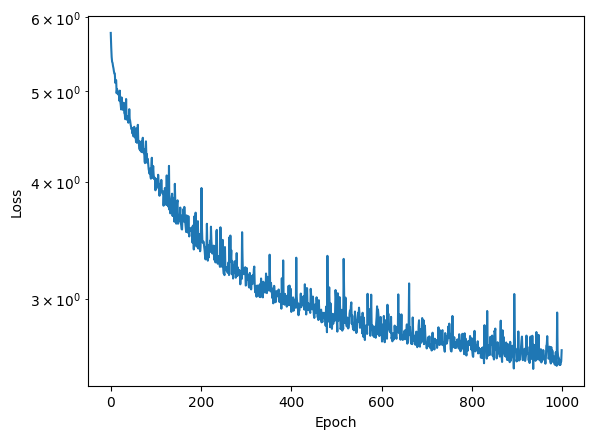

In [8]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

In [9]:
x,y = next(iter(dataloader))

In [10]:
x, y = x.to(device), y.to(device)
x=x.float().unsqueeze(-1)
x = x.permute(0, 4, 1, 2, 3)  # (N, D, H, W, C) → (N, C, D, H, W)
y = y.permute(0, 4, 1, 2, 3)
outputs = model(x)
outputs

tensor([[[[[-1.0057e+00, -1.1356e+00, -1.2078e+00,  ..., -1.0070e+00,
            -9.8051e-01, -1.0508e+00],
           [-9.2351e-01,  3.0430e-01,  4.4860e-01,  ...,  3.4437e-01,
             2.4324e-01, -9.0465e-01],
           [-9.2947e-01,  2.9370e-01,  4.3150e-01,  ...,  4.6267e-01,
             3.4083e-01, -7.9635e-01],
           ...,
           [-9.7852e-01,  4.9396e-01,  4.7700e-01,  ...,  3.9296e-01,
             3.6240e-01, -6.6964e-01],
           [-9.6659e-01,  5.0346e-01,  4.4885e-01,  ...,  3.1236e-01,
             3.8302e-01, -7.2623e-01],
           [-9.9287e-01, -1.0448e+00, -9.6395e-01,  ..., -9.6062e-01,
            -9.7719e-01, -9.4803e-01]],

          [[-1.1661e+00, -1.5684e+00, -1.6002e+00,  ..., -1.1674e+00,
            -1.2834e+00, -1.1303e+00],
           [-9.8382e-01,  1.4175e-03,  3.4806e-01,  ...,  5.4702e-01,
             1.0806e-01, -1.1104e+00],
           [-1.0514e+00, -5.8548e-02,  3.8176e-01,  ...,  5.9041e-01,
             3.8861e-01, -9.7155e-01],
 

In [11]:
y

tensor([[[[[-1.1254e+00, -1.1254e+00, -1.1254e+00,  ..., -1.1254e+00,
            -1.1254e+00, -1.1254e+00],
           [-1.1254e+00, -6.3728e-01, -6.6394e-01,  ..., -6.6493e-01,
            -6.5408e-01, -1.1254e+00],
           [-1.1254e+00, -6.3726e-01, -6.6395e-01,  ..., -6.6497e-01,
            -6.5437e-01, -1.1254e+00],
           ...,
           [-1.1254e+00, -6.3683e-01, -6.6350e-01,  ..., -6.6478e-01,
            -6.5514e-01, -1.1254e+00],
           [-1.1254e+00, -6.3687e-01, -6.6349e-01,  ..., -6.6477e-01,
            -6.5518e-01, -1.1254e+00],
           [-1.1254e+00, -1.1254e+00, -1.1254e+00,  ..., -1.1254e+00,
            -1.1254e+00, -1.1254e+00]],

          [[-1.1254e+00, -1.1254e+00, -1.1254e+00,  ..., -1.1254e+00,
            -1.1254e+00, -1.1254e+00],
           [-1.1254e+00, -7.8080e-01, -6.4096e-01,  ..., -6.3867e-01,
            -6.3572e-01, -1.1254e+00],
           [-1.1254e+00, -7.9248e-01, -6.4083e-01,  ..., -6.3863e-01,
            -6.3568e-01, -1.1254e+00],
 